Notebook uses behavior cloning on newly created RL models to imitate the MARS dataset

source: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/pretraining.ipynb

## Stable Baselines3 - Pretraining with Behavior Cloning


Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

## Introduction

In this notebook, you will learn how to record expert data, then pre-train an agent using this data
and finally continue training with Stable-Baselines3.


## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).

Notebook originally created by [skervim](https://github.com/skervim)


In [1]:
# for autoformatting
# %load_ext jupyter_black

In [2]:
# For Box2D env
# !apt-get update && apt-get install swig
# !pip install gymnasium[box2d]
# !pip install "stable-baselines3[extra]>=2.0.0a4"

In [3]:
import gymnasium as gym
from tqdm import tqdm
import numpy as np

print(f"{gym.__version__}")

0.28.1


In [4]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [5]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DDPG
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from envs.pendulum_penalizeDeflection import PendulumEnv as penalizeDeflection

In [6]:
train_config = {
    "model_type": "ddpg"
}

In [ ]:
# env = gym.make(env_id)
env_id = penalizeDeflection(render_mode='human')

## Train Expert Model

We create an expert RL agent and let it learn to solve a task by interacting with the evironment.


check the performance of the trained agent

## Create Student

We also create a student RL agent, which will later be trained with the expert dataset


In [8]:
# only valid for continuous actions
# sac_student = SAC('MlpPolicy', env_id, verbose=1, policy_kwargs=dict(net_arch=[64, 64]))
# model = SAC("MlpPolicy", env, action_noise=action_noise, verbose=1)


We now let our expert interact with the environment (except we already have expert data) and store resultant expert observations and actions to build an expert dataset.


In [9]:
num_interactions = int(4e2)

In [10]:
# from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
env = penalizeDeflection(render_mode='human')
# env = penalizeDeflection()

n_actions = env.action_space.shape[-1]
print(env.action_space)
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))


student_model = None

if train_config['model_type'] == 'ddpg':
    student_model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
else:
    student_model = SAC("MlpPolicy", env, action_noise=action_noise, verbose=1)

env = student_model.get_env()

Box(-1.0, 1.0, (1,), float32)
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
data =np.load('MARS_BC_expert_transitions.npz')
expert_actions = data['expert_actions']
expert_observations = data['expert_observations']



- To seamlessly use PyTorch in the training process, we subclass an `ExpertDataset` from PyTorch's base `Dataset`.
- Note that we initialize the dataset with the previously generated expert observations and actions.
- We further implement Python's `__getitem__` and `__len__` magic functions to allow PyTorch's dataset-handling to access arbitrary rows in the dataset and inform it about the length of the dataset.
- For more information about PyTorch's datasets, you can read: https://pytorch.org/docs/stable/data.html.


In [13]:
from torch.utils.data.dataset import Dataset, random_split

In [14]:
class ExpertDataSet(Dataset):
    def __init__(self, expert_observations, expert_actions):
        self.observations = expert_observations
        self.actions = expert_actions

    def __getitem__(self, index):
        return (self.observations[index], self.actions[index])

    def __len__(self):
        return len(self.observations)



We now instantiate the `ExpertDataSet` and split it into training and test datasets.


In [15]:
expert_dataset = ExpertDataSet(expert_observations, expert_actions)

train_size = int(0.8 * len(expert_dataset))

test_size = len(expert_dataset) - train_size

train_expert_dataset, test_expert_dataset = random_split(
    expert_dataset, [train_size, test_size]
)

In [16]:
print("test_expert_dataset: ", len(test_expert_dataset))
print("train_expert_dataset: ", len(train_expert_dataset))

test_expert_dataset:  151389
train_expert_dataset:  605556




NOTE: The supervised learning section of this code is adapted from: https://github.com/pytorch/examples/blob/master/mnist/main.py
1. We extract the policy network of our RL student agent.
2. We load the (labeled) expert dataset containing expert observations as inputs and expert actions as targets.
3. We perform supervised learning, that is, we adjust the policy network's parameters such that given expert observations as inputs to the network, its outputs match the targets (expert actions).
By training the policy network in this way the corresponding RL student agent is taught to behave like the expert agent that was used to created the expert dataset (Behavior Cloning).


In [17]:
trace = []
def pretrain_agent(
    student,
    trace=trace,
    batch_size=64,
    epochs=1000,
    scheduler_gamma=0.7,
    learning_rate=1.0,
    log_interval=100,
    no_cuda=False,
    seed=1,
    test_batch_size=64,
):
    use_cuda = not no_cuda and th.cuda.is_available()
    th.manual_seed(seed)
    device = th.device("cuda" if use_cuda else "cpu")
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    if isinstance(env.action_space, gym.spaces.Box):
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    # Extract initial policy
    model = student.policy.to(device)

    def train(model, device, train_loader, optimizer):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            if isinstance(env.action_space, gym.spaces.Box):
                # A2C/PPO policy outputs actions, values, log_prob
                # SAC/TD3 policy outputs actions only
                if isinstance(student, (A2C, PPO)):
                    action, _, _ = model(data)
                else:
                    # SAC/TD3:
                    action = model(data)
                action_prediction = action.double()
            else:
                # Retrieve the logits for A2C/PPO when using discrete actions
                dist = model.get_distribution(data)
                action_prediction = dist.distribution.logits
                target = target.long()

            loss = criterion(action_prediction, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % log_interval == 0:
                trace.append([epoch, loss.item()])
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )

    def test(model, device, test_loader):
        model.eval()
        test_loss = 0
        with th.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                if isinstance(env.action_space, gym.spaces.Box):
                    # A2C/PPO policy outputs actions, values, log_prob
                    # SAC/TD3 policy outputs actions only
                    if isinstance(student, (A2C, PPO)):
                        action, _, _ = model(data)
                    else:
                        # SAC/TD3:
                        action = model(data)
                    action_prediction = action.double()
                else:
                    # Retrieve the logits for A2C/PPO when using discrete actions
                    dist = model.get_distribution(data)
                    action_prediction = dist.distribution.logits
                    target = target.long()

                test_loss = criterion(action_prediction, target)
        test_loss /= len(test_loader.dataset)
        print(f"Test set: Average loss: {test_loss:.4f}")

    # Here, we use PyTorch `DataLoader` to our load previously created `ExpertDataset` for training
    # and testing
    train_loader = th.utils.data.DataLoader(
        dataset=train_expert_dataset, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = th.utils.data.DataLoader(
        dataset=test_expert_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        **kwargs,
    )

    # Define an Optimizer and a learning rate schedule.
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=scheduler_gamma)

    # Now we are finally ready to train the policy model.
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer)
        test(model, device, test_loader)
        scheduler.step()

    # Implant the trained policy network back into the RL student agent
    student_model.policy = model

In [18]:
trace

[]

Evaluate the agent before pretraining, it should be random

In [19]:
# mean_reward, std_reward = evaluate_policy(student_model, env, n_eval_episodes=10)

# print(f"Mean reward = {mean_reward} +/- {std_reward}")



Having defined the training procedure we can now run the pretraining!


In [20]:
epochs=100

pretrain_agent(
    student_model,
    epochs=epochs,
    scheduler_gamma=0.7,
    learning_rate=1.0,
    log_interval=100,
    no_cuda=False,
    seed=1,
    batch_size=64,
    test_batch_size=1000,
)
# student_model.save("models/sac_pretrained")

Train Epoch: 1 [0/605556 (0%)]	Loss: 0.058026
Train Epoch: 1 [6400/605556 (1%)]	Loss: 0.019852
Train Epoch: 1 [12800/605556 (2%)]	Loss: 0.018997
Train Epoch: 1 [19200/605556 (3%)]	Loss: 0.022044
Train Epoch: 1 [25600/605556 (4%)]	Loss: 0.017835
Train Epoch: 1 [32000/605556 (5%)]	Loss: 0.020316
Train Epoch: 1 [38400/605556 (6%)]	Loss: 0.020641
Train Epoch: 1 [44800/605556 (7%)]	Loss: 0.010614
Train Epoch: 1 [51200/605556 (8%)]	Loss: 0.021006
Train Epoch: 1 [57600/605556 (10%)]	Loss: 0.012999
Train Epoch: 1 [64000/605556 (11%)]	Loss: 0.010555
Train Epoch: 1 [70400/605556 (12%)]	Loss: 0.015820
Train Epoch: 1 [76800/605556 (13%)]	Loss: 0.016557
Train Epoch: 1 [83200/605556 (14%)]	Loss: 0.014680
Train Epoch: 1 [89600/605556 (15%)]	Loss: 0.011716
Train Epoch: 1 [96000/605556 (16%)]	Loss: 0.017325
Train Epoch: 1 [102400/605556 (17%)]	Loss: 0.019396
Train Epoch: 1 [108800/605556 (18%)]	Loss: 0.014780
Train Epoch: 1 [115200/605556 (19%)]	Loss: 0.014439
Train Epoch: 1 [121600/605556 (20%)]	Loss:

Train Epoch: 2 [409600/605556 (68%)]	Loss: 0.014918
Train Epoch: 2 [416000/605556 (69%)]	Loss: 0.010591
Train Epoch: 2 [422400/605556 (70%)]	Loss: 0.014784
Train Epoch: 2 [428800/605556 (71%)]	Loss: 0.023933
Train Epoch: 2 [435200/605556 (72%)]	Loss: 0.019138
Train Epoch: 2 [441600/605556 (73%)]	Loss: 0.006676
Train Epoch: 2 [448000/605556 (74%)]	Loss: 0.014028
Train Epoch: 2 [454400/605556 (75%)]	Loss: 0.019877
Train Epoch: 2 [460800/605556 (76%)]	Loss: 0.018140
Train Epoch: 2 [467200/605556 (77%)]	Loss: 0.012122
Train Epoch: 2 [473600/605556 (78%)]	Loss: 0.011838
Train Epoch: 2 [480000/605556 (79%)]	Loss: 0.012702
Train Epoch: 2 [486400/605556 (80%)]	Loss: 0.013128
Train Epoch: 2 [492800/605556 (81%)]	Loss: 0.014797
Train Epoch: 2 [499200/605556 (82%)]	Loss: 0.012886
Train Epoch: 2 [505600/605556 (83%)]	Loss: 0.006796
Train Epoch: 2 [512000/605556 (85%)]	Loss: 0.015779
Train Epoch: 2 [518400/605556 (86%)]	Loss: 0.013715
Train Epoch: 2 [524800/605556 (87%)]	Loss: 0.012589
Train Epoch:

Train Epoch: 4 [204800/605556 (34%)]	Loss: 0.007087
Train Epoch: 4 [211200/605556 (35%)]	Loss: 0.007053
Train Epoch: 4 [217600/605556 (36%)]	Loss: 0.011161
Train Epoch: 4 [224000/605556 (37%)]	Loss: 0.024317
Train Epoch: 4 [230400/605556 (38%)]	Loss: 0.018773
Train Epoch: 4 [236800/605556 (39%)]	Loss: 0.015470
Train Epoch: 4 [243200/605556 (40%)]	Loss: 0.012945
Train Epoch: 4 [249600/605556 (41%)]	Loss: 0.008919
Train Epoch: 4 [256000/605556 (42%)]	Loss: 0.018041
Train Epoch: 4 [262400/605556 (43%)]	Loss: 0.007006
Train Epoch: 4 [268800/605556 (44%)]	Loss: 0.012770
Train Epoch: 4 [275200/605556 (45%)]	Loss: 0.010207
Train Epoch: 4 [281600/605556 (47%)]	Loss: 0.007198
Train Epoch: 4 [288000/605556 (48%)]	Loss: 0.012220
Train Epoch: 4 [294400/605556 (49%)]	Loss: 0.009082
Train Epoch: 4 [300800/605556 (50%)]	Loss: 0.019420
Train Epoch: 4 [307200/605556 (51%)]	Loss: 0.020056
Train Epoch: 4 [313600/605556 (52%)]	Loss: 0.009581
Train Epoch: 4 [320000/605556 (53%)]	Loss: 0.024037
Train Epoch:

Test set: Average loss: 0.0000
Train Epoch: 6 [0/605556 (0%)]	Loss: 0.009951
Train Epoch: 6 [6400/605556 (1%)]	Loss: 0.016220
Train Epoch: 6 [12800/605556 (2%)]	Loss: 0.019769
Train Epoch: 6 [19200/605556 (3%)]	Loss: 0.014956
Train Epoch: 6 [25600/605556 (4%)]	Loss: 0.011185
Train Epoch: 6 [32000/605556 (5%)]	Loss: 0.016587
Train Epoch: 6 [38400/605556 (6%)]	Loss: 0.012783
Train Epoch: 6 [44800/605556 (7%)]	Loss: 0.014475
Train Epoch: 6 [51200/605556 (8%)]	Loss: 0.013571
Train Epoch: 6 [57600/605556 (10%)]	Loss: 0.007039
Train Epoch: 6 [64000/605556 (11%)]	Loss: 0.013792
Train Epoch: 6 [70400/605556 (12%)]	Loss: 0.016534
Train Epoch: 6 [76800/605556 (13%)]	Loss: 0.015370
Train Epoch: 6 [83200/605556 (14%)]	Loss: 0.018965
Train Epoch: 6 [89600/605556 (15%)]	Loss: 0.010710
Train Epoch: 6 [96000/605556 (16%)]	Loss: 0.013594
Train Epoch: 6 [102400/605556 (17%)]	Loss: 0.011832
Train Epoch: 6 [108800/605556 (18%)]	Loss: 0.014286
Train Epoch: 6 [115200/605556 (19%)]	Loss: 0.017886
Train Epoch

Train Epoch: 7 [403200/605556 (67%)]	Loss: 0.011463
Train Epoch: 7 [409600/605556 (68%)]	Loss: 0.011436
Train Epoch: 7 [416000/605556 (69%)]	Loss: 0.010002
Train Epoch: 7 [422400/605556 (70%)]	Loss: 0.016684
Train Epoch: 7 [428800/605556 (71%)]	Loss: 0.011196
Train Epoch: 7 [435200/605556 (72%)]	Loss: 0.017224
Train Epoch: 7 [441600/605556 (73%)]	Loss: 0.010206
Train Epoch: 7 [448000/605556 (74%)]	Loss: 0.010472
Train Epoch: 7 [454400/605556 (75%)]	Loss: 0.011215
Train Epoch: 7 [460800/605556 (76%)]	Loss: 0.015487
Train Epoch: 7 [467200/605556 (77%)]	Loss: 0.008749
Train Epoch: 7 [473600/605556 (78%)]	Loss: 0.013115
Train Epoch: 7 [480000/605556 (79%)]	Loss: 0.009377
Train Epoch: 7 [486400/605556 (80%)]	Loss: 0.007628
Train Epoch: 7 [492800/605556 (81%)]	Loss: 0.022827
Train Epoch: 7 [499200/605556 (82%)]	Loss: 0.010777
Train Epoch: 7 [505600/605556 (83%)]	Loss: 0.016680
Train Epoch: 7 [512000/605556 (85%)]	Loss: 0.015526
Train Epoch: 7 [518400/605556 (86%)]	Loss: 0.017160
Train Epoch:

Train Epoch: 9 [198400/605556 (33%)]	Loss: 0.012729
Train Epoch: 9 [204800/605556 (34%)]	Loss: 0.037893
Train Epoch: 9 [211200/605556 (35%)]	Loss: 0.011027
Train Epoch: 9 [217600/605556 (36%)]	Loss: 0.020439
Train Epoch: 9 [224000/605556 (37%)]	Loss: 0.009853
Train Epoch: 9 [230400/605556 (38%)]	Loss: 0.014949
Train Epoch: 9 [236800/605556 (39%)]	Loss: 0.007117
Train Epoch: 9 [243200/605556 (40%)]	Loss: 0.011543
Train Epoch: 9 [249600/605556 (41%)]	Loss: 0.018214
Train Epoch: 9 [256000/605556 (42%)]	Loss: 0.017517
Train Epoch: 9 [262400/605556 (43%)]	Loss: 0.018889
Train Epoch: 9 [268800/605556 (44%)]	Loss: 0.012628
Train Epoch: 9 [275200/605556 (45%)]	Loss: 0.005204
Train Epoch: 9 [281600/605556 (47%)]	Loss: 0.007272
Train Epoch: 9 [288000/605556 (48%)]	Loss: 0.016740
Train Epoch: 9 [294400/605556 (49%)]	Loss: 0.008179
Train Epoch: 9 [300800/605556 (50%)]	Loss: 0.016391
Train Epoch: 9 [307200/605556 (51%)]	Loss: 0.007122
Train Epoch: 9 [313600/605556 (52%)]	Loss: 0.017604
Train Epoch:

Train Epoch: 10 [588800/605556 (97%)]	Loss: 0.008275
Train Epoch: 10 [595200/605556 (98%)]	Loss: 0.012366
Train Epoch: 10 [601600/605556 (99%)]	Loss: 0.020611
Test set: Average loss: 0.0000
Train Epoch: 11 [0/605556 (0%)]	Loss: 0.009443
Train Epoch: 11 [6400/605556 (1%)]	Loss: 0.014304
Train Epoch: 11 [12800/605556 (2%)]	Loss: 0.019946
Train Epoch: 11 [19200/605556 (3%)]	Loss: 0.012678
Train Epoch: 11 [25600/605556 (4%)]	Loss: 0.014365
Train Epoch: 11 [32000/605556 (5%)]	Loss: 0.008998
Train Epoch: 11 [38400/605556 (6%)]	Loss: 0.014918
Train Epoch: 11 [44800/605556 (7%)]	Loss: 0.031939
Train Epoch: 11 [51200/605556 (8%)]	Loss: 0.012950
Train Epoch: 11 [57600/605556 (10%)]	Loss: 0.019261
Train Epoch: 11 [64000/605556 (11%)]	Loss: 0.017797
Train Epoch: 11 [70400/605556 (12%)]	Loss: 0.017382
Train Epoch: 11 [76800/605556 (13%)]	Loss: 0.018772
Train Epoch: 11 [83200/605556 (14%)]	Loss: 0.029143
Train Epoch: 11 [89600/605556 (15%)]	Loss: 0.008468
Train Epoch: 11 [96000/605556 (16%)]	Loss: 0

Train Epoch: 12 [364800/605556 (60%)]	Loss: 0.021428
Train Epoch: 12 [371200/605556 (61%)]	Loss: 0.024790
Train Epoch: 12 [377600/605556 (62%)]	Loss: 0.007280
Train Epoch: 12 [384000/605556 (63%)]	Loss: 0.016313
Train Epoch: 12 [390400/605556 (64%)]	Loss: 0.024210
Train Epoch: 12 [396800/605556 (66%)]	Loss: 0.011208
Train Epoch: 12 [403200/605556 (67%)]	Loss: 0.015597
Train Epoch: 12 [409600/605556 (68%)]	Loss: 0.012165
Train Epoch: 12 [416000/605556 (69%)]	Loss: 0.026516
Train Epoch: 12 [422400/605556 (70%)]	Loss: 0.010644
Train Epoch: 12 [428800/605556 (71%)]	Loss: 0.018451
Train Epoch: 12 [435200/605556 (72%)]	Loss: 0.024752
Train Epoch: 12 [441600/605556 (73%)]	Loss: 0.018457
Train Epoch: 12 [448000/605556 (74%)]	Loss: 0.019753
Train Epoch: 12 [454400/605556 (75%)]	Loss: 0.010025
Train Epoch: 12 [460800/605556 (76%)]	Loss: 0.023529
Train Epoch: 12 [467200/605556 (77%)]	Loss: 0.011029
Train Epoch: 12 [473600/605556 (78%)]	Loss: 0.026476
Train Epoch: 12 [480000/605556 (79%)]	Loss: 0.

Train Epoch: 14 [140800/605556 (23%)]	Loss: 0.015207
Train Epoch: 14 [147200/605556 (24%)]	Loss: 0.008586
Train Epoch: 14 [153600/605556 (25%)]	Loss: 0.014107
Train Epoch: 14 [160000/605556 (26%)]	Loss: 0.009869
Train Epoch: 14 [166400/605556 (27%)]	Loss: 0.013604
Train Epoch: 14 [172800/605556 (29%)]	Loss: 0.018245
Train Epoch: 14 [179200/605556 (30%)]	Loss: 0.026057
Train Epoch: 14 [185600/605556 (31%)]	Loss: 0.018386
Train Epoch: 14 [192000/605556 (32%)]	Loss: 0.017769
Train Epoch: 14 [198400/605556 (33%)]	Loss: 0.016016
Train Epoch: 14 [204800/605556 (34%)]	Loss: 0.015700
Train Epoch: 14 [211200/605556 (35%)]	Loss: 0.016122
Train Epoch: 14 [217600/605556 (36%)]	Loss: 0.007519
Train Epoch: 14 [224000/605556 (37%)]	Loss: 0.020201
Train Epoch: 14 [230400/605556 (38%)]	Loss: 0.019807
Train Epoch: 14 [236800/605556 (39%)]	Loss: 0.012856
Train Epoch: 14 [243200/605556 (40%)]	Loss: 0.009674
Train Epoch: 14 [249600/605556 (41%)]	Loss: 0.026397
Train Epoch: 14 [256000/605556 (42%)]	Loss: 0.

Train Epoch: 15 [524800/605556 (87%)]	Loss: 0.013518
Train Epoch: 15 [531200/605556 (88%)]	Loss: 0.014091
Train Epoch: 15 [537600/605556 (89%)]	Loss: 0.016002
Train Epoch: 15 [544000/605556 (90%)]	Loss: 0.021730
Train Epoch: 15 [550400/605556 (91%)]	Loss: 0.012261
Train Epoch: 15 [556800/605556 (92%)]	Loss: 0.010918
Train Epoch: 15 [563200/605556 (93%)]	Loss: 0.015435
Train Epoch: 15 [569600/605556 (94%)]	Loss: 0.049646
Train Epoch: 15 [576000/605556 (95%)]	Loss: 0.015407
Train Epoch: 15 [582400/605556 (96%)]	Loss: 0.011003
Train Epoch: 15 [588800/605556 (97%)]	Loss: 0.024267
Train Epoch: 15 [595200/605556 (98%)]	Loss: 0.013685
Train Epoch: 15 [601600/605556 (99%)]	Loss: 0.008837
Test set: Average loss: 0.0000
Train Epoch: 16 [0/605556 (0%)]	Loss: 0.013148
Train Epoch: 16 [6400/605556 (1%)]	Loss: 0.012667
Train Epoch: 16 [12800/605556 (2%)]	Loss: 0.008175
Train Epoch: 16 [19200/605556 (3%)]	Loss: 0.007954
Train Epoch: 16 [25600/605556 (4%)]	Loss: 0.015219
Train Epoch: 16 [32000/605556 

Train Epoch: 17 [300800/605556 (50%)]	Loss: 0.025581
Train Epoch: 17 [307200/605556 (51%)]	Loss: 0.017822
Train Epoch: 17 [313600/605556 (52%)]	Loss: 0.010882
Train Epoch: 17 [320000/605556 (53%)]	Loss: 0.007533
Train Epoch: 17 [326400/605556 (54%)]	Loss: 0.010525
Train Epoch: 17 [332800/605556 (55%)]	Loss: 0.004619
Train Epoch: 17 [339200/605556 (56%)]	Loss: 0.009067
Train Epoch: 17 [345600/605556 (57%)]	Loss: 0.017273
Train Epoch: 17 [352000/605556 (58%)]	Loss: 0.012655
Train Epoch: 17 [358400/605556 (59%)]	Loss: 0.007940
Train Epoch: 17 [364800/605556 (60%)]	Loss: 0.011626
Train Epoch: 17 [371200/605556 (61%)]	Loss: 0.007778
Train Epoch: 17 [377600/605556 (62%)]	Loss: 0.013189
Train Epoch: 17 [384000/605556 (63%)]	Loss: 0.009106
Train Epoch: 17 [390400/605556 (64%)]	Loss: 0.008393
Train Epoch: 17 [396800/605556 (66%)]	Loss: 0.019919
Train Epoch: 17 [403200/605556 (67%)]	Loss: 0.012567
Train Epoch: 17 [409600/605556 (68%)]	Loss: 0.012034
Train Epoch: 17 [416000/605556 (69%)]	Loss: 0.

Train Epoch: 19 [76800/605556 (13%)]	Loss: 0.017612
Train Epoch: 19 [83200/605556 (14%)]	Loss: 0.017587
Train Epoch: 19 [89600/605556 (15%)]	Loss: 0.019814
Train Epoch: 19 [96000/605556 (16%)]	Loss: 0.011190
Train Epoch: 19 [102400/605556 (17%)]	Loss: 0.015663
Train Epoch: 19 [108800/605556 (18%)]	Loss: 0.010545
Train Epoch: 19 [115200/605556 (19%)]	Loss: 0.012659
Train Epoch: 19 [121600/605556 (20%)]	Loss: 0.010772
Train Epoch: 19 [128000/605556 (21%)]	Loss: 0.010023
Train Epoch: 19 [134400/605556 (22%)]	Loss: 0.010423
Train Epoch: 19 [140800/605556 (23%)]	Loss: 0.011664
Train Epoch: 19 [147200/605556 (24%)]	Loss: 0.013107
Train Epoch: 19 [153600/605556 (25%)]	Loss: 0.008400
Train Epoch: 19 [160000/605556 (26%)]	Loss: 0.014895
Train Epoch: 19 [166400/605556 (27%)]	Loss: 0.011623
Train Epoch: 19 [172800/605556 (29%)]	Loss: 0.027032
Train Epoch: 19 [179200/605556 (30%)]	Loss: 0.011531
Train Epoch: 19 [185600/605556 (31%)]	Loss: 0.028405
Train Epoch: 19 [192000/605556 (32%)]	Loss: 0.0109

Train Epoch: 20 [460800/605556 (76%)]	Loss: 0.007810
Train Epoch: 20 [467200/605556 (77%)]	Loss: 0.011850
Train Epoch: 20 [473600/605556 (78%)]	Loss: 0.010260
Train Epoch: 20 [480000/605556 (79%)]	Loss: 0.009322
Train Epoch: 20 [486400/605556 (80%)]	Loss: 0.006278
Train Epoch: 20 [492800/605556 (81%)]	Loss: 0.012618
Train Epoch: 20 [499200/605556 (82%)]	Loss: 0.010357
Train Epoch: 20 [505600/605556 (83%)]	Loss: 0.006233
Train Epoch: 20 [512000/605556 (85%)]	Loss: 0.013891
Train Epoch: 20 [518400/605556 (86%)]	Loss: 0.017759
Train Epoch: 20 [524800/605556 (87%)]	Loss: 0.015607
Train Epoch: 20 [531200/605556 (88%)]	Loss: 0.021982
Train Epoch: 20 [537600/605556 (89%)]	Loss: 0.014881
Train Epoch: 20 [544000/605556 (90%)]	Loss: 0.014280
Train Epoch: 20 [550400/605556 (91%)]	Loss: 0.012155
Train Epoch: 20 [556800/605556 (92%)]	Loss: 0.008360
Train Epoch: 20 [563200/605556 (93%)]	Loss: 0.022971
Train Epoch: 20 [569600/605556 (94%)]	Loss: 0.012594
Train Epoch: 20 [576000/605556 (95%)]	Loss: 0.

Train Epoch: 22 [236800/605556 (39%)]	Loss: 0.015885
Train Epoch: 22 [243200/605556 (40%)]	Loss: 0.011049
Train Epoch: 22 [249600/605556 (41%)]	Loss: 0.015142
Train Epoch: 22 [256000/605556 (42%)]	Loss: 0.015651
Train Epoch: 22 [262400/605556 (43%)]	Loss: 0.014892
Train Epoch: 22 [268800/605556 (44%)]	Loss: 0.022077
Train Epoch: 22 [275200/605556 (45%)]	Loss: 0.016564
Train Epoch: 22 [281600/605556 (47%)]	Loss: 0.012492
Train Epoch: 22 [288000/605556 (48%)]	Loss: 0.018253
Train Epoch: 22 [294400/605556 (49%)]	Loss: 0.011448
Train Epoch: 22 [300800/605556 (50%)]	Loss: 0.017658
Train Epoch: 22 [307200/605556 (51%)]	Loss: 0.012433
Train Epoch: 22 [313600/605556 (52%)]	Loss: 0.009156
Train Epoch: 22 [320000/605556 (53%)]	Loss: 0.009327
Train Epoch: 22 [326400/605556 (54%)]	Loss: 0.010964
Train Epoch: 22 [332800/605556 (55%)]	Loss: 0.012705
Train Epoch: 22 [339200/605556 (56%)]	Loss: 0.024506
Train Epoch: 22 [345600/605556 (57%)]	Loss: 0.006543
Train Epoch: 22 [352000/605556 (58%)]	Loss: 0.

Train Epoch: 24 [12800/605556 (2%)]	Loss: 0.012796
Train Epoch: 24 [19200/605556 (3%)]	Loss: 0.009500
Train Epoch: 24 [25600/605556 (4%)]	Loss: 0.011966
Train Epoch: 24 [32000/605556 (5%)]	Loss: 0.018361
Train Epoch: 24 [38400/605556 (6%)]	Loss: 0.018145
Train Epoch: 24 [44800/605556 (7%)]	Loss: 0.023154
Train Epoch: 24 [51200/605556 (8%)]	Loss: 0.013876
Train Epoch: 24 [57600/605556 (10%)]	Loss: 0.016551
Train Epoch: 24 [64000/605556 (11%)]	Loss: 0.014080
Train Epoch: 24 [70400/605556 (12%)]	Loss: 0.011103
Train Epoch: 24 [76800/605556 (13%)]	Loss: 0.006298
Train Epoch: 24 [83200/605556 (14%)]	Loss: 0.007541
Train Epoch: 24 [89600/605556 (15%)]	Loss: 0.017506
Train Epoch: 24 [96000/605556 (16%)]	Loss: 0.014618
Train Epoch: 24 [102400/605556 (17%)]	Loss: 0.035857
Train Epoch: 24 [108800/605556 (18%)]	Loss: 0.019775
Train Epoch: 24 [115200/605556 (19%)]	Loss: 0.009621
Train Epoch: 24 [121600/605556 (20%)]	Loss: 0.013185
Train Epoch: 24 [128000/605556 (21%)]	Loss: 0.016612
Train Epoch: 2

Train Epoch: 25 [396800/605556 (66%)]	Loss: 0.025188
Train Epoch: 25 [403200/605556 (67%)]	Loss: 0.028278
Train Epoch: 25 [409600/605556 (68%)]	Loss: 0.017241
Train Epoch: 25 [416000/605556 (69%)]	Loss: 0.034909
Train Epoch: 25 [422400/605556 (70%)]	Loss: 0.011688
Train Epoch: 25 [428800/605556 (71%)]	Loss: 0.021035
Train Epoch: 25 [435200/605556 (72%)]	Loss: 0.012145
Train Epoch: 25 [441600/605556 (73%)]	Loss: 0.022683
Train Epoch: 25 [448000/605556 (74%)]	Loss: 0.007322
Train Epoch: 25 [454400/605556 (75%)]	Loss: 0.010643
Train Epoch: 25 [460800/605556 (76%)]	Loss: 0.010898
Train Epoch: 25 [467200/605556 (77%)]	Loss: 0.016943
Train Epoch: 25 [473600/605556 (78%)]	Loss: 0.017614
Train Epoch: 25 [480000/605556 (79%)]	Loss: 0.008104
Train Epoch: 25 [486400/605556 (80%)]	Loss: 0.014566
Train Epoch: 25 [492800/605556 (81%)]	Loss: 0.007819
Train Epoch: 25 [499200/605556 (82%)]	Loss: 0.018838
Train Epoch: 25 [505600/605556 (83%)]	Loss: 0.009473
Train Epoch: 25 [512000/605556 (85%)]	Loss: 0.

Train Epoch: 27 [172800/605556 (29%)]	Loss: 0.014166
Train Epoch: 27 [179200/605556 (30%)]	Loss: 0.009606
Train Epoch: 27 [185600/605556 (31%)]	Loss: 0.014316
Train Epoch: 27 [192000/605556 (32%)]	Loss: 0.016543
Train Epoch: 27 [198400/605556 (33%)]	Loss: 0.010994
Train Epoch: 27 [204800/605556 (34%)]	Loss: 0.016173
Train Epoch: 27 [211200/605556 (35%)]	Loss: 0.007843
Train Epoch: 27 [217600/605556 (36%)]	Loss: 0.015300
Train Epoch: 27 [224000/605556 (37%)]	Loss: 0.027812
Train Epoch: 27 [230400/605556 (38%)]	Loss: 0.005068
Train Epoch: 27 [236800/605556 (39%)]	Loss: 0.010161
Train Epoch: 27 [243200/605556 (40%)]	Loss: 0.013958
Train Epoch: 27 [249600/605556 (41%)]	Loss: 0.012908
Train Epoch: 27 [256000/605556 (42%)]	Loss: 0.007550
Train Epoch: 27 [262400/605556 (43%)]	Loss: 0.015034
Train Epoch: 27 [268800/605556 (44%)]	Loss: 0.011382
Train Epoch: 27 [275200/605556 (45%)]	Loss: 0.012515
Train Epoch: 27 [281600/605556 (47%)]	Loss: 0.014073
Train Epoch: 27 [288000/605556 (48%)]	Loss: 0.

Train Epoch: 28 [556800/605556 (92%)]	Loss: 0.011918
Train Epoch: 28 [563200/605556 (93%)]	Loss: 0.013344
Train Epoch: 28 [569600/605556 (94%)]	Loss: 0.014921
Train Epoch: 28 [576000/605556 (95%)]	Loss: 0.017015
Train Epoch: 28 [582400/605556 (96%)]	Loss: 0.012334
Train Epoch: 28 [588800/605556 (97%)]	Loss: 0.015395
Train Epoch: 28 [595200/605556 (98%)]	Loss: 0.006548
Train Epoch: 28 [601600/605556 (99%)]	Loss: 0.016097
Test set: Average loss: 0.0000
Train Epoch: 29 [0/605556 (0%)]	Loss: 0.013455
Train Epoch: 29 [6400/605556 (1%)]	Loss: 0.013405
Train Epoch: 29 [12800/605556 (2%)]	Loss: 0.015686
Train Epoch: 29 [19200/605556 (3%)]	Loss: 0.014423
Train Epoch: 29 [25600/605556 (4%)]	Loss: 0.013045
Train Epoch: 29 [32000/605556 (5%)]	Loss: 0.024553
Train Epoch: 29 [38400/605556 (6%)]	Loss: 0.005925
Train Epoch: 29 [44800/605556 (7%)]	Loss: 0.007652
Train Epoch: 29 [51200/605556 (8%)]	Loss: 0.017561
Train Epoch: 29 [57600/605556 (10%)]	Loss: 0.007036
Train Epoch: 29 [64000/605556 (11%)]	Lo

Train Epoch: 30 [332800/605556 (55%)]	Loss: 0.015574
Train Epoch: 30 [339200/605556 (56%)]	Loss: 0.019947
Train Epoch: 30 [345600/605556 (57%)]	Loss: 0.011289
Train Epoch: 30 [352000/605556 (58%)]	Loss: 0.017233
Train Epoch: 30 [358400/605556 (59%)]	Loss: 0.012445
Train Epoch: 30 [364800/605556 (60%)]	Loss: 0.009517
Train Epoch: 30 [371200/605556 (61%)]	Loss: 0.005804
Train Epoch: 30 [377600/605556 (62%)]	Loss: 0.022964
Train Epoch: 30 [384000/605556 (63%)]	Loss: 0.019174
Train Epoch: 30 [390400/605556 (64%)]	Loss: 0.012851
Train Epoch: 30 [396800/605556 (66%)]	Loss: 0.023312
Train Epoch: 30 [403200/605556 (67%)]	Loss: 0.024885
Train Epoch: 30 [409600/605556 (68%)]	Loss: 0.007977
Train Epoch: 30 [416000/605556 (69%)]	Loss: 0.010354
Train Epoch: 30 [422400/605556 (70%)]	Loss: 0.010942
Train Epoch: 30 [428800/605556 (71%)]	Loss: 0.008980
Train Epoch: 30 [435200/605556 (72%)]	Loss: 0.008604
Train Epoch: 30 [441600/605556 (73%)]	Loss: 0.015442
Train Epoch: 30 [448000/605556 (74%)]	Loss: 0.

Train Epoch: 32 [108800/605556 (18%)]	Loss: 0.011218
Train Epoch: 32 [115200/605556 (19%)]	Loss: 0.009015
Train Epoch: 32 [121600/605556 (20%)]	Loss: 0.017374
Train Epoch: 32 [128000/605556 (21%)]	Loss: 0.014222
Train Epoch: 32 [134400/605556 (22%)]	Loss: 0.029070
Train Epoch: 32 [140800/605556 (23%)]	Loss: 0.028742
Train Epoch: 32 [147200/605556 (24%)]	Loss: 0.013019
Train Epoch: 32 [153600/605556 (25%)]	Loss: 0.010481
Train Epoch: 32 [160000/605556 (26%)]	Loss: 0.022111
Train Epoch: 32 [166400/605556 (27%)]	Loss: 0.018057
Train Epoch: 32 [172800/605556 (29%)]	Loss: 0.011226
Train Epoch: 32 [179200/605556 (30%)]	Loss: 0.021833
Train Epoch: 32 [185600/605556 (31%)]	Loss: 0.013621
Train Epoch: 32 [192000/605556 (32%)]	Loss: 0.012584
Train Epoch: 32 [198400/605556 (33%)]	Loss: 0.013231
Train Epoch: 32 [204800/605556 (34%)]	Loss: 0.011005
Train Epoch: 32 [211200/605556 (35%)]	Loss: 0.013065
Train Epoch: 32 [217600/605556 (36%)]	Loss: 0.025297
Train Epoch: 32 [224000/605556 (37%)]	Loss: 0.

Train Epoch: 33 [492800/605556 (81%)]	Loss: 0.012274
Train Epoch: 33 [499200/605556 (82%)]	Loss: 0.022344
Train Epoch: 33 [505600/605556 (83%)]	Loss: 0.008704
Train Epoch: 33 [512000/605556 (85%)]	Loss: 0.017530
Train Epoch: 33 [518400/605556 (86%)]	Loss: 0.008605
Train Epoch: 33 [524800/605556 (87%)]	Loss: 0.013083
Train Epoch: 33 [531200/605556 (88%)]	Loss: 0.019319
Train Epoch: 33 [537600/605556 (89%)]	Loss: 0.019516
Train Epoch: 33 [544000/605556 (90%)]	Loss: 0.018009
Train Epoch: 33 [550400/605556 (91%)]	Loss: 0.015179
Train Epoch: 33 [556800/605556 (92%)]	Loss: 0.026626
Train Epoch: 33 [563200/605556 (93%)]	Loss: 0.013484
Train Epoch: 33 [569600/605556 (94%)]	Loss: 0.012540
Train Epoch: 33 [576000/605556 (95%)]	Loss: 0.029645
Train Epoch: 33 [582400/605556 (96%)]	Loss: 0.015402
Train Epoch: 33 [588800/605556 (97%)]	Loss: 0.005704
Train Epoch: 33 [595200/605556 (98%)]	Loss: 0.007991
Train Epoch: 33 [601600/605556 (99%)]	Loss: 0.004901
Test set: Average loss: 0.0000
Train Epoch: 34

Train Epoch: 35 [268800/605556 (44%)]	Loss: 0.017280
Train Epoch: 35 [275200/605556 (45%)]	Loss: 0.014523
Train Epoch: 35 [281600/605556 (47%)]	Loss: 0.007443
Train Epoch: 35 [288000/605556 (48%)]	Loss: 0.016016
Train Epoch: 35 [294400/605556 (49%)]	Loss: 0.014998
Train Epoch: 35 [300800/605556 (50%)]	Loss: 0.021351
Train Epoch: 35 [307200/605556 (51%)]	Loss: 0.013577
Train Epoch: 35 [313600/605556 (52%)]	Loss: 0.025633
Train Epoch: 35 [320000/605556 (53%)]	Loss: 0.012425
Train Epoch: 35 [326400/605556 (54%)]	Loss: 0.009164
Train Epoch: 35 [332800/605556 (55%)]	Loss: 0.014893
Train Epoch: 35 [339200/605556 (56%)]	Loss: 0.008607
Train Epoch: 35 [345600/605556 (57%)]	Loss: 0.007186
Train Epoch: 35 [352000/605556 (58%)]	Loss: 0.012916
Train Epoch: 35 [358400/605556 (59%)]	Loss: 0.011837
Train Epoch: 35 [364800/605556 (60%)]	Loss: 0.013881
Train Epoch: 35 [371200/605556 (61%)]	Loss: 0.021157
Train Epoch: 35 [377600/605556 (62%)]	Loss: 0.009794
Train Epoch: 35 [384000/605556 (63%)]	Loss: 0.

Train Epoch: 37 [44800/605556 (7%)]	Loss: 0.024200
Train Epoch: 37 [51200/605556 (8%)]	Loss: 0.016443
Train Epoch: 37 [57600/605556 (10%)]	Loss: 0.032359
Train Epoch: 37 [64000/605556 (11%)]	Loss: 0.012337
Train Epoch: 37 [70400/605556 (12%)]	Loss: 0.013107
Train Epoch: 37 [76800/605556 (13%)]	Loss: 0.012020
Train Epoch: 37 [83200/605556 (14%)]	Loss: 0.024910
Train Epoch: 37 [89600/605556 (15%)]	Loss: 0.009385
Train Epoch: 37 [96000/605556 (16%)]	Loss: 0.011834
Train Epoch: 37 [102400/605556 (17%)]	Loss: 0.012502
Train Epoch: 37 [108800/605556 (18%)]	Loss: 0.016083
Train Epoch: 37 [115200/605556 (19%)]	Loss: 0.020694
Train Epoch: 37 [121600/605556 (20%)]	Loss: 0.011003
Train Epoch: 37 [128000/605556 (21%)]	Loss: 0.036678
Train Epoch: 37 [134400/605556 (22%)]	Loss: 0.014269
Train Epoch: 37 [140800/605556 (23%)]	Loss: 0.020014
Train Epoch: 37 [147200/605556 (24%)]	Loss: 0.016246
Train Epoch: 37 [153600/605556 (25%)]	Loss: 0.009541
Train Epoch: 37 [160000/605556 (26%)]	Loss: 0.008648
Trai

Train Epoch: 38 [428800/605556 (71%)]	Loss: 0.013675
Train Epoch: 38 [435200/605556 (72%)]	Loss: 0.019368
Train Epoch: 38 [441600/605556 (73%)]	Loss: 0.017005
Train Epoch: 38 [448000/605556 (74%)]	Loss: 0.014075
Train Epoch: 38 [454400/605556 (75%)]	Loss: 0.023250
Train Epoch: 38 [460800/605556 (76%)]	Loss: 0.015086
Train Epoch: 38 [467200/605556 (77%)]	Loss: 0.006951
Train Epoch: 38 [473600/605556 (78%)]	Loss: 0.011927
Train Epoch: 38 [480000/605556 (79%)]	Loss: 0.013878
Train Epoch: 38 [486400/605556 (80%)]	Loss: 0.022024
Train Epoch: 38 [492800/605556 (81%)]	Loss: 0.013547
Train Epoch: 38 [499200/605556 (82%)]	Loss: 0.013198
Train Epoch: 38 [505600/605556 (83%)]	Loss: 0.014535
Train Epoch: 38 [512000/605556 (85%)]	Loss: 0.013440
Train Epoch: 38 [518400/605556 (86%)]	Loss: 0.011924
Train Epoch: 38 [524800/605556 (87%)]	Loss: 0.013953
Train Epoch: 38 [531200/605556 (88%)]	Loss: 0.023114
Train Epoch: 38 [537600/605556 (89%)]	Loss: 0.027804
Train Epoch: 38 [544000/605556 (90%)]	Loss: 0.

Train Epoch: 40 [204800/605556 (34%)]	Loss: 0.014774
Train Epoch: 40 [211200/605556 (35%)]	Loss: 0.011191
Train Epoch: 40 [217600/605556 (36%)]	Loss: 0.016612
Train Epoch: 40 [224000/605556 (37%)]	Loss: 0.013527
Train Epoch: 40 [230400/605556 (38%)]	Loss: 0.009427
Train Epoch: 40 [236800/605556 (39%)]	Loss: 0.017280
Train Epoch: 40 [243200/605556 (40%)]	Loss: 0.011130
Train Epoch: 40 [249600/605556 (41%)]	Loss: 0.012964
Train Epoch: 40 [256000/605556 (42%)]	Loss: 0.014275
Train Epoch: 40 [262400/605556 (43%)]	Loss: 0.007952
Train Epoch: 40 [268800/605556 (44%)]	Loss: 0.019255
Train Epoch: 40 [275200/605556 (45%)]	Loss: 0.010231
Train Epoch: 40 [281600/605556 (47%)]	Loss: 0.009307
Train Epoch: 40 [288000/605556 (48%)]	Loss: 0.008355
Train Epoch: 40 [294400/605556 (49%)]	Loss: 0.018906
Train Epoch: 40 [300800/605556 (50%)]	Loss: 0.023527
Train Epoch: 40 [307200/605556 (51%)]	Loss: 0.011240
Train Epoch: 40 [313600/605556 (52%)]	Loss: 0.015098
Train Epoch: 40 [320000/605556 (53%)]	Loss: 0.

Train Epoch: 41 [588800/605556 (97%)]	Loss: 0.020147
Train Epoch: 41 [595200/605556 (98%)]	Loss: 0.019190
Train Epoch: 41 [601600/605556 (99%)]	Loss: 0.015223
Test set: Average loss: 0.0000
Train Epoch: 42 [0/605556 (0%)]	Loss: 0.016125
Train Epoch: 42 [6400/605556 (1%)]	Loss: 0.009968
Train Epoch: 42 [12800/605556 (2%)]	Loss: 0.013314
Train Epoch: 42 [19200/605556 (3%)]	Loss: 0.011734
Train Epoch: 42 [25600/605556 (4%)]	Loss: 0.013023
Train Epoch: 42 [32000/605556 (5%)]	Loss: 0.014358
Train Epoch: 42 [38400/605556 (6%)]	Loss: 0.023356
Train Epoch: 42 [44800/605556 (7%)]	Loss: 0.014684
Train Epoch: 42 [51200/605556 (8%)]	Loss: 0.014367
Train Epoch: 42 [57600/605556 (10%)]	Loss: 0.016876
Train Epoch: 42 [64000/605556 (11%)]	Loss: 0.012603
Train Epoch: 42 [70400/605556 (12%)]	Loss: 0.006424
Train Epoch: 42 [76800/605556 (13%)]	Loss: 0.014317
Train Epoch: 42 [83200/605556 (14%)]	Loss: 0.009206
Train Epoch: 42 [89600/605556 (15%)]	Loss: 0.026421
Train Epoch: 42 [96000/605556 (16%)]	Loss: 0

Train Epoch: 43 [364800/605556 (60%)]	Loss: 0.014645
Train Epoch: 43 [371200/605556 (61%)]	Loss: 0.009497
Train Epoch: 43 [377600/605556 (62%)]	Loss: 0.014639
Train Epoch: 43 [384000/605556 (63%)]	Loss: 0.024356
Train Epoch: 43 [390400/605556 (64%)]	Loss: 0.026225
Train Epoch: 43 [396800/605556 (66%)]	Loss: 0.023732
Train Epoch: 43 [403200/605556 (67%)]	Loss: 0.011366
Train Epoch: 43 [409600/605556 (68%)]	Loss: 0.017302
Train Epoch: 43 [416000/605556 (69%)]	Loss: 0.011033
Train Epoch: 43 [422400/605556 (70%)]	Loss: 0.007751
Train Epoch: 43 [428800/605556 (71%)]	Loss: 0.013208
Train Epoch: 43 [435200/605556 (72%)]	Loss: 0.008333
Train Epoch: 43 [441600/605556 (73%)]	Loss: 0.010802
Train Epoch: 43 [448000/605556 (74%)]	Loss: 0.022472
Train Epoch: 43 [454400/605556 (75%)]	Loss: 0.015246
Train Epoch: 43 [460800/605556 (76%)]	Loss: 0.011166
Train Epoch: 43 [467200/605556 (77%)]	Loss: 0.009571
Train Epoch: 43 [473600/605556 (78%)]	Loss: 0.025605
Train Epoch: 43 [480000/605556 (79%)]	Loss: 0.

Train Epoch: 45 [140800/605556 (23%)]	Loss: 0.012530
Train Epoch: 45 [147200/605556 (24%)]	Loss: 0.017221
Train Epoch: 45 [153600/605556 (25%)]	Loss: 0.009380
Train Epoch: 45 [160000/605556 (26%)]	Loss: 0.012668
Train Epoch: 45 [166400/605556 (27%)]	Loss: 0.009597
Train Epoch: 45 [172800/605556 (29%)]	Loss: 0.010812
Train Epoch: 45 [179200/605556 (30%)]	Loss: 0.017028
Train Epoch: 45 [185600/605556 (31%)]	Loss: 0.006753
Train Epoch: 45 [192000/605556 (32%)]	Loss: 0.009930
Train Epoch: 45 [198400/605556 (33%)]	Loss: 0.015173
Train Epoch: 45 [204800/605556 (34%)]	Loss: 0.008654
Train Epoch: 45 [211200/605556 (35%)]	Loss: 0.012418
Train Epoch: 45 [217600/605556 (36%)]	Loss: 0.021186
Train Epoch: 45 [224000/605556 (37%)]	Loss: 0.021257
Train Epoch: 45 [230400/605556 (38%)]	Loss: 0.010323
Train Epoch: 45 [236800/605556 (39%)]	Loss: 0.008307
Train Epoch: 45 [243200/605556 (40%)]	Loss: 0.017941
Train Epoch: 45 [249600/605556 (41%)]	Loss: 0.011805
Train Epoch: 45 [256000/605556 (42%)]	Loss: 0.

Train Epoch: 46 [524800/605556 (87%)]	Loss: 0.019187
Train Epoch: 46 [531200/605556 (88%)]	Loss: 0.011910
Train Epoch: 46 [537600/605556 (89%)]	Loss: 0.013695
Train Epoch: 46 [544000/605556 (90%)]	Loss: 0.016240
Train Epoch: 46 [550400/605556 (91%)]	Loss: 0.015664
Train Epoch: 46 [556800/605556 (92%)]	Loss: 0.021143
Train Epoch: 46 [563200/605556 (93%)]	Loss: 0.008344
Train Epoch: 46 [569600/605556 (94%)]	Loss: 0.012480
Train Epoch: 46 [576000/605556 (95%)]	Loss: 0.046071
Train Epoch: 46 [582400/605556 (96%)]	Loss: 0.013388
Train Epoch: 46 [588800/605556 (97%)]	Loss: 0.023652
Train Epoch: 46 [595200/605556 (98%)]	Loss: 0.003828
Train Epoch: 46 [601600/605556 (99%)]	Loss: 0.013525
Test set: Average loss: 0.0000
Train Epoch: 47 [0/605556 (0%)]	Loss: 0.018704
Train Epoch: 47 [6400/605556 (1%)]	Loss: 0.013044
Train Epoch: 47 [12800/605556 (2%)]	Loss: 0.019174
Train Epoch: 47 [19200/605556 (3%)]	Loss: 0.015713
Train Epoch: 47 [25600/605556 (4%)]	Loss: 0.010982
Train Epoch: 47 [32000/605556 

Train Epoch: 48 [300800/605556 (50%)]	Loss: 0.012895
Train Epoch: 48 [307200/605556 (51%)]	Loss: 0.023435
Train Epoch: 48 [313600/605556 (52%)]	Loss: 0.014414
Train Epoch: 48 [320000/605556 (53%)]	Loss: 0.014225
Train Epoch: 48 [326400/605556 (54%)]	Loss: 0.019193
Train Epoch: 48 [332800/605556 (55%)]	Loss: 0.023266
Train Epoch: 48 [339200/605556 (56%)]	Loss: 0.006448
Train Epoch: 48 [345600/605556 (57%)]	Loss: 0.019985
Train Epoch: 48 [352000/605556 (58%)]	Loss: 0.022918
Train Epoch: 48 [358400/605556 (59%)]	Loss: 0.019599
Train Epoch: 48 [364800/605556 (60%)]	Loss: 0.013005
Train Epoch: 48 [371200/605556 (61%)]	Loss: 0.010366
Train Epoch: 48 [377600/605556 (62%)]	Loss: 0.014169
Train Epoch: 48 [384000/605556 (63%)]	Loss: 0.022939
Train Epoch: 48 [390400/605556 (64%)]	Loss: 0.005264
Train Epoch: 48 [396800/605556 (66%)]	Loss: 0.007843
Train Epoch: 48 [403200/605556 (67%)]	Loss: 0.017451
Train Epoch: 48 [409600/605556 (68%)]	Loss: 0.020656
Train Epoch: 48 [416000/605556 (69%)]	Loss: 0.

Train Epoch: 50 [76800/605556 (13%)]	Loss: 0.011332
Train Epoch: 50 [83200/605556 (14%)]	Loss: 0.006396
Train Epoch: 50 [89600/605556 (15%)]	Loss: 0.007186
Train Epoch: 50 [96000/605556 (16%)]	Loss: 0.019846
Train Epoch: 50 [102400/605556 (17%)]	Loss: 0.016077
Train Epoch: 50 [108800/605556 (18%)]	Loss: 0.015497
Train Epoch: 50 [115200/605556 (19%)]	Loss: 0.014015
Train Epoch: 50 [121600/605556 (20%)]	Loss: 0.015923
Train Epoch: 50 [128000/605556 (21%)]	Loss: 0.016179
Train Epoch: 50 [134400/605556 (22%)]	Loss: 0.012592
Train Epoch: 50 [140800/605556 (23%)]	Loss: 0.011294
Train Epoch: 50 [147200/605556 (24%)]	Loss: 0.010422
Train Epoch: 50 [153600/605556 (25%)]	Loss: 0.015338
Train Epoch: 50 [160000/605556 (26%)]	Loss: 0.010000
Train Epoch: 50 [166400/605556 (27%)]	Loss: 0.014946
Train Epoch: 50 [172800/605556 (29%)]	Loss: 0.010220
Train Epoch: 50 [179200/605556 (30%)]	Loss: 0.015888
Train Epoch: 50 [185600/605556 (31%)]	Loss: 0.019315
Train Epoch: 50 [192000/605556 (32%)]	Loss: 0.0145

Train Epoch: 51 [460800/605556 (76%)]	Loss: 0.014485
Train Epoch: 51 [467200/605556 (77%)]	Loss: 0.018027
Train Epoch: 51 [473600/605556 (78%)]	Loss: 0.027176
Train Epoch: 51 [480000/605556 (79%)]	Loss: 0.017823
Train Epoch: 51 [486400/605556 (80%)]	Loss: 0.018759
Train Epoch: 51 [492800/605556 (81%)]	Loss: 0.013181
Train Epoch: 51 [499200/605556 (82%)]	Loss: 0.011884
Train Epoch: 51 [505600/605556 (83%)]	Loss: 0.009670
Train Epoch: 51 [512000/605556 (85%)]	Loss: 0.021265
Train Epoch: 51 [518400/605556 (86%)]	Loss: 0.007227
Train Epoch: 51 [524800/605556 (87%)]	Loss: 0.022386
Train Epoch: 51 [531200/605556 (88%)]	Loss: 0.011343
Train Epoch: 51 [537600/605556 (89%)]	Loss: 0.028520
Train Epoch: 51 [544000/605556 (90%)]	Loss: 0.008140
Train Epoch: 51 [550400/605556 (91%)]	Loss: 0.015489
Train Epoch: 51 [556800/605556 (92%)]	Loss: 0.018197
Train Epoch: 51 [563200/605556 (93%)]	Loss: 0.020832
Train Epoch: 51 [569600/605556 (94%)]	Loss: 0.012232
Train Epoch: 51 [576000/605556 (95%)]	Loss: 0.

Train Epoch: 53 [236800/605556 (39%)]	Loss: 0.010965
Train Epoch: 53 [243200/605556 (40%)]	Loss: 0.008963
Train Epoch: 53 [249600/605556 (41%)]	Loss: 0.010659
Train Epoch: 53 [256000/605556 (42%)]	Loss: 0.016938
Train Epoch: 53 [262400/605556 (43%)]	Loss: 0.014372
Train Epoch: 53 [268800/605556 (44%)]	Loss: 0.016139
Train Epoch: 53 [275200/605556 (45%)]	Loss: 0.015883
Train Epoch: 53 [281600/605556 (47%)]	Loss: 0.011751
Train Epoch: 53 [288000/605556 (48%)]	Loss: 0.017313
Train Epoch: 53 [294400/605556 (49%)]	Loss: 0.014830
Train Epoch: 53 [300800/605556 (50%)]	Loss: 0.012899
Train Epoch: 53 [307200/605556 (51%)]	Loss: 0.013956
Train Epoch: 53 [313600/605556 (52%)]	Loss: 0.018149
Train Epoch: 53 [320000/605556 (53%)]	Loss: 0.021182
Train Epoch: 53 [326400/605556 (54%)]	Loss: 0.025537
Train Epoch: 53 [332800/605556 (55%)]	Loss: 0.010894
Train Epoch: 53 [339200/605556 (56%)]	Loss: 0.009703
Train Epoch: 53 [345600/605556 (57%)]	Loss: 0.010108
Train Epoch: 53 [352000/605556 (58%)]	Loss: 0.

Train Epoch: 55 [12800/605556 (2%)]	Loss: 0.018962
Train Epoch: 55 [19200/605556 (3%)]	Loss: 0.009166
Train Epoch: 55 [25600/605556 (4%)]	Loss: 0.011550
Train Epoch: 55 [32000/605556 (5%)]	Loss: 0.047122
Train Epoch: 55 [38400/605556 (6%)]	Loss: 0.026800
Train Epoch: 55 [44800/605556 (7%)]	Loss: 0.026148
Train Epoch: 55 [51200/605556 (8%)]	Loss: 0.014003
Train Epoch: 55 [57600/605556 (10%)]	Loss: 0.010153
Train Epoch: 55 [64000/605556 (11%)]	Loss: 0.017011
Train Epoch: 55 [70400/605556 (12%)]	Loss: 0.010079
Train Epoch: 55 [76800/605556 (13%)]	Loss: 0.008775
Train Epoch: 55 [83200/605556 (14%)]	Loss: 0.008077
Train Epoch: 55 [89600/605556 (15%)]	Loss: 0.023445
Train Epoch: 55 [96000/605556 (16%)]	Loss: 0.015652
Train Epoch: 55 [102400/605556 (17%)]	Loss: 0.027149
Train Epoch: 55 [108800/605556 (18%)]	Loss: 0.009912
Train Epoch: 55 [115200/605556 (19%)]	Loss: 0.006628
Train Epoch: 55 [121600/605556 (20%)]	Loss: 0.005115
Train Epoch: 55 [128000/605556 (21%)]	Loss: 0.011650
Train Epoch: 5

Train Epoch: 56 [396800/605556 (66%)]	Loss: 0.011942
Train Epoch: 56 [403200/605556 (67%)]	Loss: 0.017947
Train Epoch: 56 [409600/605556 (68%)]	Loss: 0.049733
Train Epoch: 56 [416000/605556 (69%)]	Loss: 0.020963
Train Epoch: 56 [422400/605556 (70%)]	Loss: 0.017557
Train Epoch: 56 [428800/605556 (71%)]	Loss: 0.016594
Train Epoch: 56 [435200/605556 (72%)]	Loss: 0.019701
Train Epoch: 56 [441600/605556 (73%)]	Loss: 0.020146
Train Epoch: 56 [448000/605556 (74%)]	Loss: 0.028190
Train Epoch: 56 [454400/605556 (75%)]	Loss: 0.015920
Train Epoch: 56 [460800/605556 (76%)]	Loss: 0.013285
Train Epoch: 56 [467200/605556 (77%)]	Loss: 0.009634
Train Epoch: 56 [473600/605556 (78%)]	Loss: 0.015091
Train Epoch: 56 [480000/605556 (79%)]	Loss: 0.006833
Train Epoch: 56 [486400/605556 (80%)]	Loss: 0.012465
Train Epoch: 56 [492800/605556 (81%)]	Loss: 0.023936
Train Epoch: 56 [499200/605556 (82%)]	Loss: 0.012654
Train Epoch: 56 [505600/605556 (83%)]	Loss: 0.013408
Train Epoch: 56 [512000/605556 (85%)]	Loss: 0.

Train Epoch: 58 [172800/605556 (29%)]	Loss: 0.014797
Train Epoch: 58 [179200/605556 (30%)]	Loss: 0.011144
Train Epoch: 58 [185600/605556 (31%)]	Loss: 0.011907
Train Epoch: 58 [192000/605556 (32%)]	Loss: 0.013360
Train Epoch: 58 [198400/605556 (33%)]	Loss: 0.038650
Train Epoch: 58 [204800/605556 (34%)]	Loss: 0.011053
Train Epoch: 58 [211200/605556 (35%)]	Loss: 0.019885
Train Epoch: 58 [217600/605556 (36%)]	Loss: 0.015042
Train Epoch: 58 [224000/605556 (37%)]	Loss: 0.019457
Train Epoch: 58 [230400/605556 (38%)]	Loss: 0.020682
Train Epoch: 58 [236800/605556 (39%)]	Loss: 0.023829
Train Epoch: 58 [243200/605556 (40%)]	Loss: 0.010296
Train Epoch: 58 [249600/605556 (41%)]	Loss: 0.018578
Train Epoch: 58 [256000/605556 (42%)]	Loss: 0.011811
Train Epoch: 58 [262400/605556 (43%)]	Loss: 0.015110
Train Epoch: 58 [268800/605556 (44%)]	Loss: 0.010617
Train Epoch: 58 [275200/605556 (45%)]	Loss: 0.007327
Train Epoch: 58 [281600/605556 (47%)]	Loss: 0.012861
Train Epoch: 58 [288000/605556 (48%)]	Loss: 0.

Train Epoch: 59 [556800/605556 (92%)]	Loss: 0.009853
Train Epoch: 59 [563200/605556 (93%)]	Loss: 0.014957
Train Epoch: 59 [569600/605556 (94%)]	Loss: 0.010258
Train Epoch: 59 [576000/605556 (95%)]	Loss: 0.021744
Train Epoch: 59 [582400/605556 (96%)]	Loss: 0.010318
Train Epoch: 59 [588800/605556 (97%)]	Loss: 0.014577
Train Epoch: 59 [595200/605556 (98%)]	Loss: 0.011898
Train Epoch: 59 [601600/605556 (99%)]	Loss: 0.013743
Test set: Average loss: 0.0000
Train Epoch: 60 [0/605556 (0%)]	Loss: 0.014774
Train Epoch: 60 [6400/605556 (1%)]	Loss: 0.017808
Train Epoch: 60 [12800/605556 (2%)]	Loss: 0.006942
Train Epoch: 60 [19200/605556 (3%)]	Loss: 0.013348
Train Epoch: 60 [25600/605556 (4%)]	Loss: 0.004683
Train Epoch: 60 [32000/605556 (5%)]	Loss: 0.015684
Train Epoch: 60 [38400/605556 (6%)]	Loss: 0.018255
Train Epoch: 60 [44800/605556 (7%)]	Loss: 0.009339
Train Epoch: 60 [51200/605556 (8%)]	Loss: 0.010593
Train Epoch: 60 [57600/605556 (10%)]	Loss: 0.014889
Train Epoch: 60 [64000/605556 (11%)]	Lo

Train Epoch: 61 [332800/605556 (55%)]	Loss: 0.014665
Train Epoch: 61 [339200/605556 (56%)]	Loss: 0.009962
Train Epoch: 61 [345600/605556 (57%)]	Loss: 0.007712
Train Epoch: 61 [352000/605556 (58%)]	Loss: 0.018923
Train Epoch: 61 [358400/605556 (59%)]	Loss: 0.007666
Train Epoch: 61 [364800/605556 (60%)]	Loss: 0.021807
Train Epoch: 61 [371200/605556 (61%)]	Loss: 0.014321
Train Epoch: 61 [377600/605556 (62%)]	Loss: 0.028562
Train Epoch: 61 [384000/605556 (63%)]	Loss: 0.017555
Train Epoch: 61 [390400/605556 (64%)]	Loss: 0.021370
Train Epoch: 61 [396800/605556 (66%)]	Loss: 0.008761
Train Epoch: 61 [403200/605556 (67%)]	Loss: 0.022016
Train Epoch: 61 [409600/605556 (68%)]	Loss: 0.007953
Train Epoch: 61 [416000/605556 (69%)]	Loss: 0.013332
Train Epoch: 61 [422400/605556 (70%)]	Loss: 0.011283
Train Epoch: 61 [428800/605556 (71%)]	Loss: 0.009569
Train Epoch: 61 [435200/605556 (72%)]	Loss: 0.009668
Train Epoch: 61 [441600/605556 (73%)]	Loss: 0.007272
Train Epoch: 61 [448000/605556 (74%)]	Loss: 0.

Train Epoch: 63 [108800/605556 (18%)]	Loss: 0.014070
Train Epoch: 63 [115200/605556 (19%)]	Loss: 0.012787
Train Epoch: 63 [121600/605556 (20%)]	Loss: 0.010454
Train Epoch: 63 [128000/605556 (21%)]	Loss: 0.010306
Train Epoch: 63 [134400/605556 (22%)]	Loss: 0.012217
Train Epoch: 63 [140800/605556 (23%)]	Loss: 0.012245
Train Epoch: 63 [147200/605556 (24%)]	Loss: 0.006913
Train Epoch: 63 [153600/605556 (25%)]	Loss: 0.022866
Train Epoch: 63 [160000/605556 (26%)]	Loss: 0.016072
Train Epoch: 63 [166400/605556 (27%)]	Loss: 0.018730
Train Epoch: 63 [172800/605556 (29%)]	Loss: 0.016366
Train Epoch: 63 [179200/605556 (30%)]	Loss: 0.009977
Train Epoch: 63 [185600/605556 (31%)]	Loss: 0.011855
Train Epoch: 63 [192000/605556 (32%)]	Loss: 0.023192
Train Epoch: 63 [198400/605556 (33%)]	Loss: 0.006142
Train Epoch: 63 [204800/605556 (34%)]	Loss: 0.011829
Train Epoch: 63 [211200/605556 (35%)]	Loss: 0.019859
Train Epoch: 63 [217600/605556 (36%)]	Loss: 0.007569
Train Epoch: 63 [224000/605556 (37%)]	Loss: 0.

Train Epoch: 64 [492800/605556 (81%)]	Loss: 0.010027
Train Epoch: 64 [499200/605556 (82%)]	Loss: 0.016907
Train Epoch: 64 [505600/605556 (83%)]	Loss: 0.018127
Train Epoch: 64 [512000/605556 (85%)]	Loss: 0.016653
Train Epoch: 64 [518400/605556 (86%)]	Loss: 0.012452
Train Epoch: 64 [524800/605556 (87%)]	Loss: 0.016563
Train Epoch: 64 [531200/605556 (88%)]	Loss: 0.043135
Train Epoch: 64 [537600/605556 (89%)]	Loss: 0.008884
Train Epoch: 64 [544000/605556 (90%)]	Loss: 0.024007
Train Epoch: 64 [550400/605556 (91%)]	Loss: 0.007702
Train Epoch: 64 [556800/605556 (92%)]	Loss: 0.007532
Train Epoch: 64 [563200/605556 (93%)]	Loss: 0.010573
Train Epoch: 64 [569600/605556 (94%)]	Loss: 0.013628
Train Epoch: 64 [576000/605556 (95%)]	Loss: 0.020537
Train Epoch: 64 [582400/605556 (96%)]	Loss: 0.026127
Train Epoch: 64 [588800/605556 (97%)]	Loss: 0.012122
Train Epoch: 64 [595200/605556 (98%)]	Loss: 0.005953
Train Epoch: 64 [601600/605556 (99%)]	Loss: 0.013071
Test set: Average loss: 0.0000
Train Epoch: 65

Train Epoch: 66 [268800/605556 (44%)]	Loss: 0.011020
Train Epoch: 66 [275200/605556 (45%)]	Loss: 0.008233
Train Epoch: 66 [281600/605556 (47%)]	Loss: 0.010457
Train Epoch: 66 [288000/605556 (48%)]	Loss: 0.013066
Train Epoch: 66 [294400/605556 (49%)]	Loss: 0.019129
Train Epoch: 66 [300800/605556 (50%)]	Loss: 0.018181
Train Epoch: 66 [307200/605556 (51%)]	Loss: 0.008115
Train Epoch: 66 [313600/605556 (52%)]	Loss: 0.012921
Train Epoch: 66 [320000/605556 (53%)]	Loss: 0.014863
Train Epoch: 66 [326400/605556 (54%)]	Loss: 0.028102
Train Epoch: 66 [332800/605556 (55%)]	Loss: 0.010788
Train Epoch: 66 [339200/605556 (56%)]	Loss: 0.009270
Train Epoch: 66 [345600/605556 (57%)]	Loss: 0.011854
Train Epoch: 66 [352000/605556 (58%)]	Loss: 0.018747
Train Epoch: 66 [358400/605556 (59%)]	Loss: 0.012934
Train Epoch: 66 [364800/605556 (60%)]	Loss: 0.019233
Train Epoch: 66 [371200/605556 (61%)]	Loss: 0.015000
Train Epoch: 66 [377600/605556 (62%)]	Loss: 0.014647
Train Epoch: 66 [384000/605556 (63%)]	Loss: 0.

Train Epoch: 68 [44800/605556 (7%)]	Loss: 0.021121
Train Epoch: 68 [51200/605556 (8%)]	Loss: 0.011451
Train Epoch: 68 [57600/605556 (10%)]	Loss: 0.016328
Train Epoch: 68 [64000/605556 (11%)]	Loss: 0.013304
Train Epoch: 68 [70400/605556 (12%)]	Loss: 0.026970
Train Epoch: 68 [76800/605556 (13%)]	Loss: 0.011522
Train Epoch: 68 [83200/605556 (14%)]	Loss: 0.012145
Train Epoch: 68 [89600/605556 (15%)]	Loss: 0.011591
Train Epoch: 68 [96000/605556 (16%)]	Loss: 0.023869
Train Epoch: 68 [102400/605556 (17%)]	Loss: 0.007798
Train Epoch: 68 [108800/605556 (18%)]	Loss: 0.019691
Train Epoch: 68 [115200/605556 (19%)]	Loss: 0.006732
Train Epoch: 68 [121600/605556 (20%)]	Loss: 0.019861
Train Epoch: 68 [128000/605556 (21%)]	Loss: 0.011235
Train Epoch: 68 [134400/605556 (22%)]	Loss: 0.017968
Train Epoch: 68 [140800/605556 (23%)]	Loss: 0.022570
Train Epoch: 68 [147200/605556 (24%)]	Loss: 0.028593
Train Epoch: 68 [153600/605556 (25%)]	Loss: 0.011413
Train Epoch: 68 [160000/605556 (26%)]	Loss: 0.011086
Trai

Train Epoch: 69 [428800/605556 (71%)]	Loss: 0.011491
Train Epoch: 69 [435200/605556 (72%)]	Loss: 0.009467
Train Epoch: 69 [441600/605556 (73%)]	Loss: 0.027814
Train Epoch: 69 [448000/605556 (74%)]	Loss: 0.015257
Train Epoch: 69 [454400/605556 (75%)]	Loss: 0.012905
Train Epoch: 69 [460800/605556 (76%)]	Loss: 0.012826
Train Epoch: 69 [467200/605556 (77%)]	Loss: 0.012644
Train Epoch: 69 [473600/605556 (78%)]	Loss: 0.017841
Train Epoch: 69 [480000/605556 (79%)]	Loss: 0.014760
Train Epoch: 69 [486400/605556 (80%)]	Loss: 0.012662
Train Epoch: 69 [492800/605556 (81%)]	Loss: 0.013129
Train Epoch: 69 [499200/605556 (82%)]	Loss: 0.018678
Train Epoch: 69 [505600/605556 (83%)]	Loss: 0.029474
Train Epoch: 69 [512000/605556 (85%)]	Loss: 0.017010
Train Epoch: 69 [518400/605556 (86%)]	Loss: 0.012232
Train Epoch: 69 [524800/605556 (87%)]	Loss: 0.020491
Train Epoch: 69 [531200/605556 (88%)]	Loss: 0.009357
Train Epoch: 69 [537600/605556 (89%)]	Loss: 0.012644
Train Epoch: 69 [544000/605556 (90%)]	Loss: 0.

Train Epoch: 71 [204800/605556 (34%)]	Loss: 0.013901
Train Epoch: 71 [211200/605556 (35%)]	Loss: 0.013229
Train Epoch: 71 [217600/605556 (36%)]	Loss: 0.014677
Train Epoch: 71 [224000/605556 (37%)]	Loss: 0.010231
Train Epoch: 71 [230400/605556 (38%)]	Loss: 0.022573
Train Epoch: 71 [236800/605556 (39%)]	Loss: 0.012116
Train Epoch: 71 [243200/605556 (40%)]	Loss: 0.016103
Train Epoch: 71 [249600/605556 (41%)]	Loss: 0.017492
Train Epoch: 71 [256000/605556 (42%)]	Loss: 0.014039
Train Epoch: 71 [262400/605556 (43%)]	Loss: 0.024042
Train Epoch: 71 [268800/605556 (44%)]	Loss: 0.018766
Train Epoch: 71 [275200/605556 (45%)]	Loss: 0.029925
Train Epoch: 71 [281600/605556 (47%)]	Loss: 0.013349
Train Epoch: 71 [288000/605556 (48%)]	Loss: 0.013040
Train Epoch: 71 [294400/605556 (49%)]	Loss: 0.021059
Train Epoch: 71 [300800/605556 (50%)]	Loss: 0.015121
Train Epoch: 71 [307200/605556 (51%)]	Loss: 0.007641
Train Epoch: 71 [313600/605556 (52%)]	Loss: 0.016080
Train Epoch: 71 [320000/605556 (53%)]	Loss: 0.

Train Epoch: 72 [588800/605556 (97%)]	Loss: 0.010978
Train Epoch: 72 [595200/605556 (98%)]	Loss: 0.008797
Train Epoch: 72 [601600/605556 (99%)]	Loss: 0.011935
Test set: Average loss: 0.0000
Train Epoch: 73 [0/605556 (0%)]	Loss: 0.010127
Train Epoch: 73 [6400/605556 (1%)]	Loss: 0.006925
Train Epoch: 73 [12800/605556 (2%)]	Loss: 0.033490
Train Epoch: 73 [19200/605556 (3%)]	Loss: 0.023717
Train Epoch: 73 [25600/605556 (4%)]	Loss: 0.013104
Train Epoch: 73 [32000/605556 (5%)]	Loss: 0.009602
Train Epoch: 73 [38400/605556 (6%)]	Loss: 0.009487
Train Epoch: 73 [44800/605556 (7%)]	Loss: 0.009836
Train Epoch: 73 [51200/605556 (8%)]	Loss: 0.013637
Train Epoch: 73 [57600/605556 (10%)]	Loss: 0.011615
Train Epoch: 73 [64000/605556 (11%)]	Loss: 0.019405
Train Epoch: 73 [70400/605556 (12%)]	Loss: 0.022732
Train Epoch: 73 [76800/605556 (13%)]	Loss: 0.010935
Train Epoch: 73 [83200/605556 (14%)]	Loss: 0.012671
Train Epoch: 73 [89600/605556 (15%)]	Loss: 0.017998
Train Epoch: 73 [96000/605556 (16%)]	Loss: 0

Train Epoch: 74 [364800/605556 (60%)]	Loss: 0.012382
Train Epoch: 74 [371200/605556 (61%)]	Loss: 0.028786
Train Epoch: 74 [377600/605556 (62%)]	Loss: 0.007336
Train Epoch: 74 [384000/605556 (63%)]	Loss: 0.036188
Train Epoch: 74 [390400/605556 (64%)]	Loss: 0.013087
Train Epoch: 74 [396800/605556 (66%)]	Loss: 0.016436
Train Epoch: 74 [403200/605556 (67%)]	Loss: 0.023289
Train Epoch: 74 [409600/605556 (68%)]	Loss: 0.016935
Train Epoch: 74 [416000/605556 (69%)]	Loss: 0.015602
Train Epoch: 74 [422400/605556 (70%)]	Loss: 0.022358
Train Epoch: 74 [428800/605556 (71%)]	Loss: 0.020029
Train Epoch: 74 [435200/605556 (72%)]	Loss: 0.012082
Train Epoch: 74 [441600/605556 (73%)]	Loss: 0.016921
Train Epoch: 74 [448000/605556 (74%)]	Loss: 0.012276
Train Epoch: 74 [454400/605556 (75%)]	Loss: 0.023110
Train Epoch: 74 [460800/605556 (76%)]	Loss: 0.025964
Train Epoch: 74 [467200/605556 (77%)]	Loss: 0.013470
Train Epoch: 74 [473600/605556 (78%)]	Loss: 0.025143
Train Epoch: 74 [480000/605556 (79%)]	Loss: 0.

Train Epoch: 76 [140800/605556 (23%)]	Loss: 0.018207
Train Epoch: 76 [147200/605556 (24%)]	Loss: 0.016246
Train Epoch: 76 [153600/605556 (25%)]	Loss: 0.010961
Train Epoch: 76 [160000/605556 (26%)]	Loss: 0.018849
Train Epoch: 76 [166400/605556 (27%)]	Loss: 0.016684
Train Epoch: 76 [172800/605556 (29%)]	Loss: 0.010102
Train Epoch: 76 [179200/605556 (30%)]	Loss: 0.021891
Train Epoch: 76 [185600/605556 (31%)]	Loss: 0.024789
Train Epoch: 76 [192000/605556 (32%)]	Loss: 0.013917
Train Epoch: 76 [198400/605556 (33%)]	Loss: 0.015046
Train Epoch: 76 [204800/605556 (34%)]	Loss: 0.020265
Train Epoch: 76 [211200/605556 (35%)]	Loss: 0.015562
Train Epoch: 76 [217600/605556 (36%)]	Loss: 0.009615
Train Epoch: 76 [224000/605556 (37%)]	Loss: 0.016606
Train Epoch: 76 [230400/605556 (38%)]	Loss: 0.010175
Train Epoch: 76 [236800/605556 (39%)]	Loss: 0.017471
Train Epoch: 76 [243200/605556 (40%)]	Loss: 0.021706
Train Epoch: 76 [249600/605556 (41%)]	Loss: 0.020231
Train Epoch: 76 [256000/605556 (42%)]	Loss: 0.

Train Epoch: 77 [524800/605556 (87%)]	Loss: 0.014903
Train Epoch: 77 [531200/605556 (88%)]	Loss: 0.012502
Train Epoch: 77 [537600/605556 (89%)]	Loss: 0.011686
Train Epoch: 77 [544000/605556 (90%)]	Loss: 0.022406
Train Epoch: 77 [550400/605556 (91%)]	Loss: 0.020483
Train Epoch: 77 [556800/605556 (92%)]	Loss: 0.014247
Train Epoch: 77 [563200/605556 (93%)]	Loss: 0.018830
Train Epoch: 77 [569600/605556 (94%)]	Loss: 0.010435
Train Epoch: 77 [576000/605556 (95%)]	Loss: 0.008301
Train Epoch: 77 [582400/605556 (96%)]	Loss: 0.012228
Train Epoch: 77 [588800/605556 (97%)]	Loss: 0.004311
Train Epoch: 77 [595200/605556 (98%)]	Loss: 0.016870
Train Epoch: 77 [601600/605556 (99%)]	Loss: 0.008512
Test set: Average loss: 0.0000
Train Epoch: 78 [0/605556 (0%)]	Loss: 0.008563
Train Epoch: 78 [6400/605556 (1%)]	Loss: 0.012208
Train Epoch: 78 [12800/605556 (2%)]	Loss: 0.007752
Train Epoch: 78 [19200/605556 (3%)]	Loss: 0.015809
Train Epoch: 78 [25600/605556 (4%)]	Loss: 0.013156
Train Epoch: 78 [32000/605556 

Train Epoch: 79 [300800/605556 (50%)]	Loss: 0.006177
Train Epoch: 79 [307200/605556 (51%)]	Loss: 0.010416
Train Epoch: 79 [313600/605556 (52%)]	Loss: 0.009770
Train Epoch: 79 [320000/605556 (53%)]	Loss: 0.010306
Train Epoch: 79 [326400/605556 (54%)]	Loss: 0.021003
Train Epoch: 79 [332800/605556 (55%)]	Loss: 0.013829
Train Epoch: 79 [339200/605556 (56%)]	Loss: 0.012038
Train Epoch: 79 [345600/605556 (57%)]	Loss: 0.007330
Train Epoch: 79 [352000/605556 (58%)]	Loss: 0.024884
Train Epoch: 79 [358400/605556 (59%)]	Loss: 0.013957
Train Epoch: 79 [364800/605556 (60%)]	Loss: 0.014938
Train Epoch: 79 [371200/605556 (61%)]	Loss: 0.019317
Train Epoch: 79 [377600/605556 (62%)]	Loss: 0.016880
Train Epoch: 79 [384000/605556 (63%)]	Loss: 0.025496
Train Epoch: 79 [390400/605556 (64%)]	Loss: 0.015074
Train Epoch: 79 [396800/605556 (66%)]	Loss: 0.017183
Train Epoch: 79 [403200/605556 (67%)]	Loss: 0.011448
Train Epoch: 79 [409600/605556 (68%)]	Loss: 0.012582
Train Epoch: 79 [416000/605556 (69%)]	Loss: 0.

Train Epoch: 81 [76800/605556 (13%)]	Loss: 0.016875
Train Epoch: 81 [83200/605556 (14%)]	Loss: 0.013969
Train Epoch: 81 [89600/605556 (15%)]	Loss: 0.021335
Train Epoch: 81 [96000/605556 (16%)]	Loss: 0.008232
Train Epoch: 81 [102400/605556 (17%)]	Loss: 0.014329
Train Epoch: 81 [108800/605556 (18%)]	Loss: 0.019862
Train Epoch: 81 [115200/605556 (19%)]	Loss: 0.008992
Train Epoch: 81 [121600/605556 (20%)]	Loss: 0.009746
Train Epoch: 81 [128000/605556 (21%)]	Loss: 0.012464
Train Epoch: 81 [134400/605556 (22%)]	Loss: 0.018406
Train Epoch: 81 [140800/605556 (23%)]	Loss: 0.030018
Train Epoch: 81 [147200/605556 (24%)]	Loss: 0.008097
Train Epoch: 81 [153600/605556 (25%)]	Loss: 0.014516
Train Epoch: 81 [160000/605556 (26%)]	Loss: 0.022285
Train Epoch: 81 [166400/605556 (27%)]	Loss: 0.028178
Train Epoch: 81 [172800/605556 (29%)]	Loss: 0.016480
Train Epoch: 81 [179200/605556 (30%)]	Loss: 0.025772
Train Epoch: 81 [185600/605556 (31%)]	Loss: 0.014097
Train Epoch: 81 [192000/605556 (32%)]	Loss: 0.0271

Train Epoch: 82 [460800/605556 (76%)]	Loss: 0.007699
Train Epoch: 82 [467200/605556 (77%)]	Loss: 0.021388
Train Epoch: 82 [473600/605556 (78%)]	Loss: 0.009447
Train Epoch: 82 [480000/605556 (79%)]	Loss: 0.016514
Train Epoch: 82 [486400/605556 (80%)]	Loss: 0.011621
Train Epoch: 82 [492800/605556 (81%)]	Loss: 0.017128
Train Epoch: 82 [499200/605556 (82%)]	Loss: 0.019847
Train Epoch: 82 [505600/605556 (83%)]	Loss: 0.012139
Train Epoch: 82 [512000/605556 (85%)]	Loss: 0.010232
Train Epoch: 82 [518400/605556 (86%)]	Loss: 0.017983
Train Epoch: 82 [524800/605556 (87%)]	Loss: 0.014803
Train Epoch: 82 [531200/605556 (88%)]	Loss: 0.013420
Train Epoch: 82 [537600/605556 (89%)]	Loss: 0.011515
Train Epoch: 82 [544000/605556 (90%)]	Loss: 0.021327
Train Epoch: 82 [550400/605556 (91%)]	Loss: 0.018812
Train Epoch: 82 [556800/605556 (92%)]	Loss: 0.010171
Train Epoch: 82 [563200/605556 (93%)]	Loss: 0.006955
Train Epoch: 82 [569600/605556 (94%)]	Loss: 0.017780
Train Epoch: 82 [576000/605556 (95%)]	Loss: 0.

Train Epoch: 84 [236800/605556 (39%)]	Loss: 0.021930
Train Epoch: 84 [243200/605556 (40%)]	Loss: 0.012322
Train Epoch: 84 [249600/605556 (41%)]	Loss: 0.016158
Train Epoch: 84 [256000/605556 (42%)]	Loss: 0.022832
Train Epoch: 84 [262400/605556 (43%)]	Loss: 0.015069
Train Epoch: 84 [268800/605556 (44%)]	Loss: 0.022409
Train Epoch: 84 [275200/605556 (45%)]	Loss: 0.025308
Train Epoch: 84 [281600/605556 (47%)]	Loss: 0.005212
Train Epoch: 84 [288000/605556 (48%)]	Loss: 0.020000
Train Epoch: 84 [294400/605556 (49%)]	Loss: 0.017743
Train Epoch: 84 [300800/605556 (50%)]	Loss: 0.022802
Train Epoch: 84 [307200/605556 (51%)]	Loss: 0.007811
Train Epoch: 84 [313600/605556 (52%)]	Loss: 0.011731
Train Epoch: 84 [320000/605556 (53%)]	Loss: 0.015681
Train Epoch: 84 [326400/605556 (54%)]	Loss: 0.018526
Train Epoch: 84 [332800/605556 (55%)]	Loss: 0.010311
Train Epoch: 84 [339200/605556 (56%)]	Loss: 0.018167
Train Epoch: 84 [345600/605556 (57%)]	Loss: 0.021413
Train Epoch: 84 [352000/605556 (58%)]	Loss: 0.

Train Epoch: 86 [12800/605556 (2%)]	Loss: 0.014840
Train Epoch: 86 [19200/605556 (3%)]	Loss: 0.017960
Train Epoch: 86 [25600/605556 (4%)]	Loss: 0.021690
Train Epoch: 86 [32000/605556 (5%)]	Loss: 0.017096
Train Epoch: 86 [38400/605556 (6%)]	Loss: 0.016896
Train Epoch: 86 [44800/605556 (7%)]	Loss: 0.013159
Train Epoch: 86 [51200/605556 (8%)]	Loss: 0.019831
Train Epoch: 86 [57600/605556 (10%)]	Loss: 0.014250
Train Epoch: 86 [64000/605556 (11%)]	Loss: 0.011169
Train Epoch: 86 [70400/605556 (12%)]	Loss: 0.015465
Train Epoch: 86 [76800/605556 (13%)]	Loss: 0.020373
Train Epoch: 86 [83200/605556 (14%)]	Loss: 0.025808
Train Epoch: 86 [89600/605556 (15%)]	Loss: 0.028018
Train Epoch: 86 [96000/605556 (16%)]	Loss: 0.017335
Train Epoch: 86 [102400/605556 (17%)]	Loss: 0.020250
Train Epoch: 86 [108800/605556 (18%)]	Loss: 0.008303
Train Epoch: 86 [115200/605556 (19%)]	Loss: 0.015373
Train Epoch: 86 [121600/605556 (20%)]	Loss: 0.025728
Train Epoch: 86 [128000/605556 (21%)]	Loss: 0.018359
Train Epoch: 8

Train Epoch: 87 [396800/605556 (66%)]	Loss: 0.018012
Train Epoch: 87 [403200/605556 (67%)]	Loss: 0.016017
Train Epoch: 87 [409600/605556 (68%)]	Loss: 0.011372
Train Epoch: 87 [416000/605556 (69%)]	Loss: 0.007667
Train Epoch: 87 [422400/605556 (70%)]	Loss: 0.010293
Train Epoch: 87 [428800/605556 (71%)]	Loss: 0.017933
Train Epoch: 87 [435200/605556 (72%)]	Loss: 0.021490
Train Epoch: 87 [441600/605556 (73%)]	Loss: 0.013619
Train Epoch: 87 [448000/605556 (74%)]	Loss: 0.010028
Train Epoch: 87 [454400/605556 (75%)]	Loss: 0.015348
Train Epoch: 87 [460800/605556 (76%)]	Loss: 0.008303
Train Epoch: 87 [467200/605556 (77%)]	Loss: 0.012247
Train Epoch: 87 [473600/605556 (78%)]	Loss: 0.023889
Train Epoch: 87 [480000/605556 (79%)]	Loss: 0.019090
Train Epoch: 87 [486400/605556 (80%)]	Loss: 0.008503
Train Epoch: 87 [492800/605556 (81%)]	Loss: 0.008559
Train Epoch: 87 [499200/605556 (82%)]	Loss: 0.008165
Train Epoch: 87 [505600/605556 (83%)]	Loss: 0.015506
Train Epoch: 87 [512000/605556 (85%)]	Loss: 0.

Train Epoch: 89 [172800/605556 (29%)]	Loss: 0.007192
Train Epoch: 89 [179200/605556 (30%)]	Loss: 0.009791
Train Epoch: 89 [185600/605556 (31%)]	Loss: 0.009933
Train Epoch: 89 [192000/605556 (32%)]	Loss: 0.010536
Train Epoch: 89 [198400/605556 (33%)]	Loss: 0.022044
Train Epoch: 89 [204800/605556 (34%)]	Loss: 0.006416
Train Epoch: 89 [211200/605556 (35%)]	Loss: 0.021043
Train Epoch: 89 [217600/605556 (36%)]	Loss: 0.027605
Train Epoch: 89 [224000/605556 (37%)]	Loss: 0.018757
Train Epoch: 89 [230400/605556 (38%)]	Loss: 0.012910
Train Epoch: 89 [236800/605556 (39%)]	Loss: 0.010059
Train Epoch: 89 [243200/605556 (40%)]	Loss: 0.013606
Train Epoch: 89 [249600/605556 (41%)]	Loss: 0.018879
Train Epoch: 89 [256000/605556 (42%)]	Loss: 0.007731
Train Epoch: 89 [262400/605556 (43%)]	Loss: 0.011744
Train Epoch: 89 [268800/605556 (44%)]	Loss: 0.007763
Train Epoch: 89 [275200/605556 (45%)]	Loss: 0.024063
Train Epoch: 89 [281600/605556 (47%)]	Loss: 0.013161
Train Epoch: 89 [288000/605556 (48%)]	Loss: 0.

Train Epoch: 90 [556800/605556 (92%)]	Loss: 0.016891
Train Epoch: 90 [563200/605556 (93%)]	Loss: 0.021861
Train Epoch: 90 [569600/605556 (94%)]	Loss: 0.007441
Train Epoch: 90 [576000/605556 (95%)]	Loss: 0.009916
Train Epoch: 90 [582400/605556 (96%)]	Loss: 0.017568
Train Epoch: 90 [588800/605556 (97%)]	Loss: 0.007876
Train Epoch: 90 [595200/605556 (98%)]	Loss: 0.023467
Train Epoch: 90 [601600/605556 (99%)]	Loss: 0.012969
Test set: Average loss: 0.0000
Train Epoch: 91 [0/605556 (0%)]	Loss: 0.013290
Train Epoch: 91 [6400/605556 (1%)]	Loss: 0.009020
Train Epoch: 91 [12800/605556 (2%)]	Loss: 0.012290
Train Epoch: 91 [19200/605556 (3%)]	Loss: 0.007881
Train Epoch: 91 [25600/605556 (4%)]	Loss: 0.012551
Train Epoch: 91 [32000/605556 (5%)]	Loss: 0.019018
Train Epoch: 91 [38400/605556 (6%)]	Loss: 0.015460
Train Epoch: 91 [44800/605556 (7%)]	Loss: 0.009612
Train Epoch: 91 [51200/605556 (8%)]	Loss: 0.018766
Train Epoch: 91 [57600/605556 (10%)]	Loss: 0.012273
Train Epoch: 91 [64000/605556 (11%)]	Lo

Train Epoch: 92 [332800/605556 (55%)]	Loss: 0.015634
Train Epoch: 92 [339200/605556 (56%)]	Loss: 0.016222
Train Epoch: 92 [345600/605556 (57%)]	Loss: 0.014554
Train Epoch: 92 [352000/605556 (58%)]	Loss: 0.010578
Train Epoch: 92 [358400/605556 (59%)]	Loss: 0.015799
Train Epoch: 92 [364800/605556 (60%)]	Loss: 0.011047
Train Epoch: 92 [371200/605556 (61%)]	Loss: 0.009597
Train Epoch: 92 [377600/605556 (62%)]	Loss: 0.011489
Train Epoch: 92 [384000/605556 (63%)]	Loss: 0.018586
Train Epoch: 92 [390400/605556 (64%)]	Loss: 0.017114
Train Epoch: 92 [396800/605556 (66%)]	Loss: 0.009277
Train Epoch: 92 [403200/605556 (67%)]	Loss: 0.031610
Train Epoch: 92 [409600/605556 (68%)]	Loss: 0.016154
Train Epoch: 92 [416000/605556 (69%)]	Loss: 0.023355
Train Epoch: 92 [422400/605556 (70%)]	Loss: 0.009118
Train Epoch: 92 [428800/605556 (71%)]	Loss: 0.014381
Train Epoch: 92 [435200/605556 (72%)]	Loss: 0.010560
Train Epoch: 92 [441600/605556 (73%)]	Loss: 0.019681
Train Epoch: 92 [448000/605556 (74%)]	Loss: 0.

Train Epoch: 94 [108800/605556 (18%)]	Loss: 0.011569
Train Epoch: 94 [115200/605556 (19%)]	Loss: 0.018003
Train Epoch: 94 [121600/605556 (20%)]	Loss: 0.015412
Train Epoch: 94 [128000/605556 (21%)]	Loss: 0.010052
Train Epoch: 94 [134400/605556 (22%)]	Loss: 0.029781
Train Epoch: 94 [140800/605556 (23%)]	Loss: 0.018072
Train Epoch: 94 [147200/605556 (24%)]	Loss: 0.009725
Train Epoch: 94 [153600/605556 (25%)]	Loss: 0.022120
Train Epoch: 94 [160000/605556 (26%)]	Loss: 0.009900
Train Epoch: 94 [166400/605556 (27%)]	Loss: 0.011854
Train Epoch: 94 [172800/605556 (29%)]	Loss: 0.030668
Train Epoch: 94 [179200/605556 (30%)]	Loss: 0.010280
Train Epoch: 94 [185600/605556 (31%)]	Loss: 0.024536
Train Epoch: 94 [192000/605556 (32%)]	Loss: 0.007731
Train Epoch: 94 [198400/605556 (33%)]	Loss: 0.014927
Train Epoch: 94 [204800/605556 (34%)]	Loss: 0.013687
Train Epoch: 94 [211200/605556 (35%)]	Loss: 0.019286
Train Epoch: 94 [217600/605556 (36%)]	Loss: 0.011780
Train Epoch: 94 [224000/605556 (37%)]	Loss: 0.

Train Epoch: 95 [492800/605556 (81%)]	Loss: 0.008295
Train Epoch: 95 [499200/605556 (82%)]	Loss: 0.021663
Train Epoch: 95 [505600/605556 (83%)]	Loss: 0.008827
Train Epoch: 95 [512000/605556 (85%)]	Loss: 0.011022
Train Epoch: 95 [518400/605556 (86%)]	Loss: 0.034365
Train Epoch: 95 [524800/605556 (87%)]	Loss: 0.010755
Train Epoch: 95 [531200/605556 (88%)]	Loss: 0.015781
Train Epoch: 95 [537600/605556 (89%)]	Loss: 0.028039
Train Epoch: 95 [544000/605556 (90%)]	Loss: 0.007900
Train Epoch: 95 [550400/605556 (91%)]	Loss: 0.008170
Train Epoch: 95 [556800/605556 (92%)]	Loss: 0.028797
Train Epoch: 95 [563200/605556 (93%)]	Loss: 0.006168
Train Epoch: 95 [569600/605556 (94%)]	Loss: 0.009931
Train Epoch: 95 [576000/605556 (95%)]	Loss: 0.010467
Train Epoch: 95 [582400/605556 (96%)]	Loss: 0.014339
Train Epoch: 95 [588800/605556 (97%)]	Loss: 0.008675
Train Epoch: 95 [595200/605556 (98%)]	Loss: 0.022256
Train Epoch: 95 [601600/605556 (99%)]	Loss: 0.012792
Test set: Average loss: 0.0000
Train Epoch: 96

Train Epoch: 97 [268800/605556 (44%)]	Loss: 0.007698
Train Epoch: 97 [275200/605556 (45%)]	Loss: 0.007321
Train Epoch: 97 [281600/605556 (47%)]	Loss: 0.010285
Train Epoch: 97 [288000/605556 (48%)]	Loss: 0.014923
Train Epoch: 97 [294400/605556 (49%)]	Loss: 0.021266
Train Epoch: 97 [300800/605556 (50%)]	Loss: 0.012608
Train Epoch: 97 [307200/605556 (51%)]	Loss: 0.020583
Train Epoch: 97 [313600/605556 (52%)]	Loss: 0.012092
Train Epoch: 97 [320000/605556 (53%)]	Loss: 0.013661
Train Epoch: 97 [326400/605556 (54%)]	Loss: 0.010540
Train Epoch: 97 [332800/605556 (55%)]	Loss: 0.012409
Train Epoch: 97 [339200/605556 (56%)]	Loss: 0.019088
Train Epoch: 97 [345600/605556 (57%)]	Loss: 0.024760
Train Epoch: 97 [352000/605556 (58%)]	Loss: 0.014083
Train Epoch: 97 [358400/605556 (59%)]	Loss: 0.017224
Train Epoch: 97 [364800/605556 (60%)]	Loss: 0.011074
Train Epoch: 97 [371200/605556 (61%)]	Loss: 0.013030
Train Epoch: 97 [377600/605556 (62%)]	Loss: 0.007597
Train Epoch: 97 [384000/605556 (63%)]	Loss: 0.

Train Epoch: 99 [44800/605556 (7%)]	Loss: 0.023004
Train Epoch: 99 [51200/605556 (8%)]	Loss: 0.009497
Train Epoch: 99 [57600/605556 (10%)]	Loss: 0.006881
Train Epoch: 99 [64000/605556 (11%)]	Loss: 0.016463
Train Epoch: 99 [70400/605556 (12%)]	Loss: 0.013280
Train Epoch: 99 [76800/605556 (13%)]	Loss: 0.008875
Train Epoch: 99 [83200/605556 (14%)]	Loss: 0.032124
Train Epoch: 99 [89600/605556 (15%)]	Loss: 0.015468
Train Epoch: 99 [96000/605556 (16%)]	Loss: 0.012494
Train Epoch: 99 [102400/605556 (17%)]	Loss: 0.010998
Train Epoch: 99 [108800/605556 (18%)]	Loss: 0.013535
Train Epoch: 99 [115200/605556 (19%)]	Loss: 0.014052
Train Epoch: 99 [121600/605556 (20%)]	Loss: 0.011703
Train Epoch: 99 [128000/605556 (21%)]	Loss: 0.009337
Train Epoch: 99 [134400/605556 (22%)]	Loss: 0.021092
Train Epoch: 99 [140800/605556 (23%)]	Loss: 0.015760
Train Epoch: 99 [147200/605556 (24%)]	Loss: 0.007326
Train Epoch: 99 [153600/605556 (25%)]	Loss: 0.028632
Train Epoch: 99 [160000/605556 (26%)]	Loss: 0.011367
Trai

Train Epoch: 100 [422400/605556 (70%)]	Loss: 0.010539
Train Epoch: 100 [428800/605556 (71%)]	Loss: 0.041500
Train Epoch: 100 [435200/605556 (72%)]	Loss: 0.013354
Train Epoch: 100 [441600/605556 (73%)]	Loss: 0.013695
Train Epoch: 100 [448000/605556 (74%)]	Loss: 0.011573
Train Epoch: 100 [454400/605556 (75%)]	Loss: 0.021156
Train Epoch: 100 [460800/605556 (76%)]	Loss: 0.015064
Train Epoch: 100 [467200/605556 (77%)]	Loss: 0.016038
Train Epoch: 100 [473600/605556 (78%)]	Loss: 0.010404
Train Epoch: 100 [480000/605556 (79%)]	Loss: 0.039759
Train Epoch: 100 [486400/605556 (80%)]	Loss: 0.006799
Train Epoch: 100 [492800/605556 (81%)]	Loss: 0.018449
Train Epoch: 100 [499200/605556 (82%)]	Loss: 0.008347
Train Epoch: 100 [505600/605556 (83%)]	Loss: 0.017447
Train Epoch: 100 [512000/605556 (85%)]	Loss: 0.020237
Train Epoch: 100 [518400/605556 (86%)]	Loss: 0.005084
Train Epoch: 100 [524800/605556 (87%)]	Loss: 0.011565
Train Epoch: 100 [531200/605556 (88%)]	Loss: 0.010974
Train Epoch: 100 [537600/605

In [21]:
trace = np.array(trace)
trace

array([[1.00000000e+00, 5.80259651e-02],
       [1.00000000e+00, 1.98521560e-02],
       [1.00000000e+00, 1.89973793e-02],
       ...,
       [1.00000000e+02, 2.15185848e-02],
       [1.00000000e+02, 7.69387518e-03],
       [1.00000000e+02, 1.64807238e-02]])

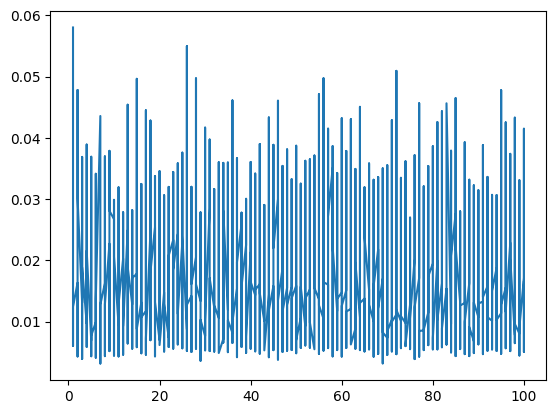

In [22]:

import matplotlib.pyplot as plt
plt.plot(trace[:,0], trace[:,1])
plt.show()

In [23]:
# student_model.learn(total_timesteps=10000, log_interval=10)

In [24]:
# need to run the 'train_pretrained_model.ipynb' notebook to complete training
student_model.save(f"./saved_models/{train_config['model_type']}_bc_new_{epochs}_epochs")



Finally, let us test how well our RL agent student learned to mimic the behavior of the expert


In [25]:
# mean_reward, std_reward = evaluate_policy(student_model, env, n_eval_episodes=10)

# print(f"Mean reward = {mean_reward} +/- {std_reward}")